# Модель предсказания оценки отзыва посетителя отеля

Датасет содержит сведения об отзывах на отели Европы. Модель должна предсказывать оценку отзыва посетителя отеля по данным сайта Booking на основе имеющихся в датасете данных. Для оценки качества решения используется результат метрики MAPE.

In [2]:
import re
import ast # безопасное преобразование строк в списки

import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

import category_encoders as ce
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn import preprocessing
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

from geopy.geocoders import Nominatim # разбор адресов, получение коорднат
from geopy.distance import geodesic
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer # интерпретация тональности текста
nltk.downloader.download('vader_lexicon') # Загрузка данных для работы

# Графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Проверка гипотез
from scipy import stats

# Обучение модели  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\g-022\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Обзор данных

Исходный датасет содержит 17 полей со следующей информацией:

- **hotel_address** — адрес отеля;
- **review_date** — дата, когда рецензент разместил соответствующий отзыв;
- **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- **hotel_name** — название отеля;
- **reviewer_nationality** — страна рецензента;
- **negative_review** — отрицательный отзыв, который рецензент дал отелю;
- **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
- **positive_review** — положительный отзыв, который рецензент дал отелю;
- **review_total_positive_word_counts** — общее количество слов в положительном отзыве.
- **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
- **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
- **total_number_of_reviews** — общее количество действительных отзывов об отеле;
- **tags** — теги, которые рецензент дал отелю;
- **days_since_review** — количество дней между датой проверки и датой очистки;
- **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- **lat** — географическая широта отеля;
- **lng** — географическая долгота отеля.

In [3]:
init_df_hotels_train = pd.read_csv('./data/hotels_train.csv')
display(init_df_hotels_train.head())
print(f'Размерность датасета: {init_df_hotels_train.shape}')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


Размерность датасета: (386803, 17)


Удаляем полные дубликаты только из тренировочных данных, чтобы не повредить тестовые.

In [4]:
init_count = init_df_hotels_train.shape[0]
# Удаление дубликатов
init_df_hotels_train = init_df_hotels_train.drop_duplicates(ignore_index=True)
print(init_count - init_df_hotels_train.shape[0])

307


В исходных данных присутствовало 307 дублирующих записей.  

Загрузим и объединим с тренировочными данными набор тестовых данных для увеличения объема выборки каждого признака, а также для их одновременного преобразования.

In [5]:
init_df_hotels_test = pd.read_csv('./data/hotels_test.csv')
display(init_df_hotels_test.head())
print(f'Размерность датасета: {init_df_hotels_test.shape}')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


Размерность датасета: (128935, 16)


In [6]:
# Объединение наборов данных
init_df_hotels_train['is_test_dataset'] = False
init_df_hotels_test['is_test_dataset'] = True
init_df_hotels_test['reviewer_score'] = 0

init_df_hotels = pd.concat([init_df_hotels_train, init_df_hotels_test])

In [7]:
init_df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515431 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 10  r

In [8]:
df_hotels = init_df_hotels.copy()
# Преобразование review_date в тип даты
df_hotels['review_date'] = pd.to_datetime(df_hotels['review_date'], dayfirst=False)
# Преобразование days_since_review
df_hotels['days_since_review'] = df_hotels['days_since_review'].apply(lambda x: str(x).split(' ')[0]).astype('int64')
# Получение списков строковых и числовых признаков
list_str_sign = []
list_num_sign = []
for sign in df_hotels.columns:
    if pd.api.types.is_numeric_dtype(df_hotels[sign].dtype):
        list_num_sign.append(sign)
    elif pd.api.types.is_object_dtype(df_hotels[sign].dtype):
        list_str_sign.append(sign)
        
# Удаляем из списка служебный признак
list_num_sign.remove('is_test_dataset')

print('Числовые признаки:', *list_num_sign, sep='\n')
print('-' * 50)
print('Строковые признаки:', *list_str_sign, sep='\n')

Числовые признаки:
additional_number_of_scoring
average_score
review_total_negative_word_counts
total_number_of_reviews
review_total_positive_word_counts
total_number_of_reviews_reviewer_has_given
reviewer_score
days_since_review
lat
lng
--------------------------------------------------
Строковые признаки:
hotel_address
hotel_name
reviewer_nationality
negative_review
positive_review
tags


## Очистка данных и одномерный анализ

### Удаление полных дубликатов

Проведено ранее только на выборке тренировочных данных.

### Обработка пропусков

In [9]:
# Получение списка признаков с пропусками
cols_null_persent = df_hotels.isnull().mean() * 100
cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.634032
lng    0.634032
dtype: float64

Пропуски наблюдаются в географических координатах отеля. Так как адрес отеля заполнен для всех записей, то можно заполнить географические координаты с использованием библиотеки geopy. Если адрес не распознается библиотекой, сокращаем его "масштаб".

In [10]:
def get_coord_by_addr(addr: str):
    ''' Функция возвращает координаты по адресу, если в первичном виде
        адрес не найден, сокращает его и вызывает рекурсивно.
    Args:
        addr (str): Строка, содержащая адрес
    Returns:
        (float, float): Координаты, если полностью адрес не найден, 
        возвращает (0, 0)
    '''
    if addr == '':
        return (0, 0)
    geolocator = Nominatim(user_agent="geo_expert")
    location = geolocator.geocode(addr, timeout=10)
    if location:
        return (location.latitude, location.longitude)
    else:
        addr = addr.split(' ')
        addr = ' '.join(addr[1:])
        return get_coord_by_addr(addr)


# Получение списка адресов без координат
list_loss_addr = list(df_hotels[df_hotels['lat'].isnull()]['hotel_address'].drop_duplicates())
# Получение словаря с координатами по адресам
dict_loss_addr = {}
for addr in list_loss_addr:
    dict_loss_addr[addr] = get_coord_by_addr(addr)

Пропущенные значения заполняются из полученного словаря.

In [11]:
# Заполнение пропущенных значений
df_hotels['lat'] = df_hotels.apply(lambda x: dict_loss_addr.get(x['hotel_address'], (np.NaN, np.NaN))[0] if pd.isna(x['lat']) else x['lat'], axis=1)
df_hotels['lng'] = df_hotels.apply(lambda x: dict_loss_addr.get(x['hotel_address'], (np.NaN, np.NaN))[1] if pd.isna(x['lng']) else x['lng'], axis=1)

# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df_hotels.isnull().sum().sum()}')

Количество пропущенных значений: 0


Все пропущенные значения заполнены.

### Обзор выбросов

In [12]:
# Расшифровка признаков
dict_col_name_rus = {'hotel_address': 'Адрес отеля',
                     'review_date': 'Дата отзыва',
                     'average_score': 'Средний балл отеля за последний год',
                     'hotel_name': 'Название отеля',
                     'reviewer_nationality': 'Страна рецензента',
                     'negative_review': 'Отрицательный отзыв рецензента',
                     'review_total_negative_word_counts': 'Общее количество слов отрицательного отзыва',
                     'positive_review': 'Положительный отзыв рецензента',
                     'review_total_positive_word_counts': 'Общее количество слов положительного отзыва',
                     'reviewer_score': 'Оценка рецензента',
                     'total_number_of_reviews_reviewer_has_given': 'Количество отзывов отеля',
                     'total_number_of_reviews': 'Общее количество действительных отзывов отеля',
                     'tags': 'Теги из отзыва',
                     'days_since_review': 'Количество дней между датой проверки и датой очистки',
                     'additional_number_of_scoring': 'Количество действительных оценок без проверки',
                     'lat': 'Географическая широта отеля',
                     'lng': 'Географическая долгота отеля'}

#### Числовые признаки

In [13]:
def plot_numerical_feature(data: pd.DataFrame, col: str, main_title: str):
    ''' Функция отрисовывает коробчатую диаграмму и гистограмму распределения
    и выводит статистические данные числового признака.
    Args:
        data (pd.DataFrame): датасет
        col (str): наименование признака
        main_title (str): расшифровка наименования признака для вывода
            в титуле графика
    Returns:
        None
    '''
    # Инициализация полотна на два графика с общей осью X
    fig_col = make_subplots(rows=2, cols=1,
                            shared_xaxes=True, # Общая ось Х
                            x_title=main_title,
                            y_title='Количество',
                            row_heights=[0.15, 0.85], # Относительная высота полотен
                            subplot_titles=(f"Распределение признака <br>\"{main_title}\"", ""),
                            vertical_spacing=0.02) # Высота разделителя
    # Построение коробчатой диаграммы
    fig_col.add_trace(go.Box(x=data[col],
                             marker_color = '#1729B0', # Цвет маркера
                             jitter=0.5, # Разнос точек выбросов по вертикали
                             name='',
                             showlegend=False),
                      row=1, col=1)
    # Построение гистограммы
    fig_col.add_trace(go.Histogram(x=data[col],
                                   marker_color = '#1729B0', # Цвет маркера
                                   name=main_title, # Название набора данных
                                   showlegend=False),
                      row=2, col=1)
    # Построение линии среднего значения
    fig_col.add_vline(x=data[col].mean(),
                      line=dict(color="Red", dash='dash')) # Стиль линии
    # Размер полотна
    fig_col.update_layout(autosize = False, width = 1000, height = 550,
                          bargap=0.1) # Расстояние между столбцами гистограммы
    fig_col.show('png')

    print('Статистические данные признака:')
    display(data[col].describe().round(2))

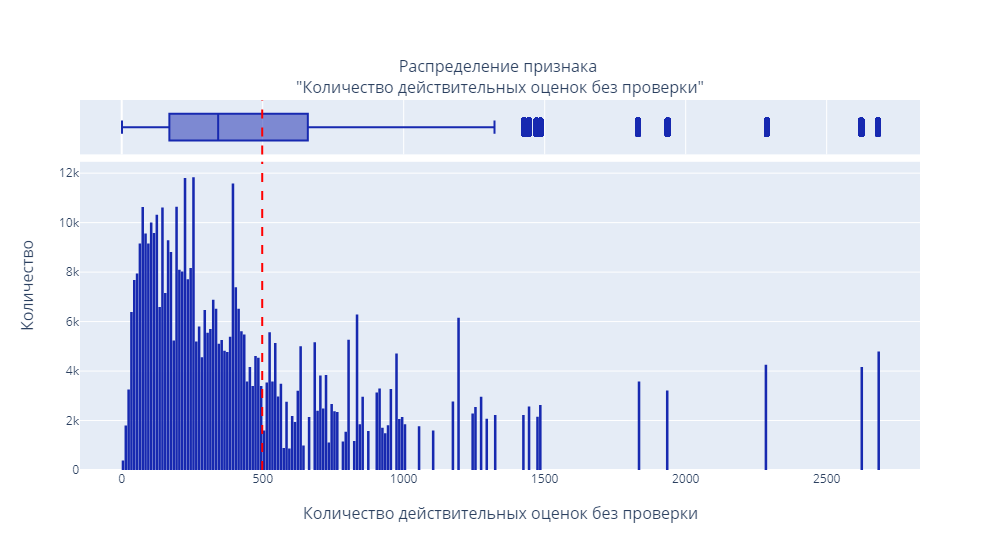

Статистические данные признака:


count    515431.00
mean        498.28
std         500.62
min           1.00
25%         169.00
50%         342.00
75%         660.00
max        2682.00
Name: additional_number_of_scoring, dtype: float64

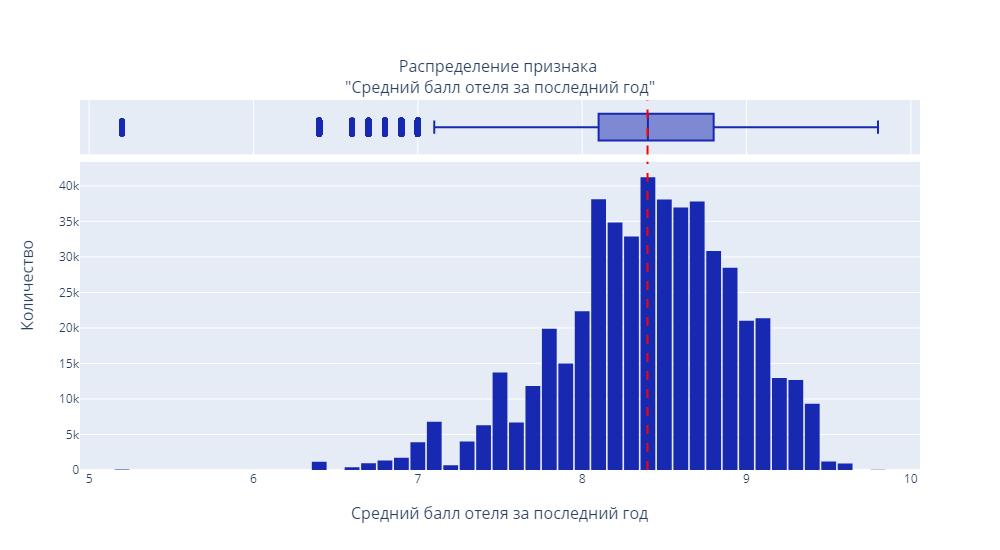

Статистические данные признака:


count    515431.00
mean          8.40
std           0.55
min           5.20
25%           8.10
50%           8.40
75%           8.80
max           9.80
Name: average_score, dtype: float64

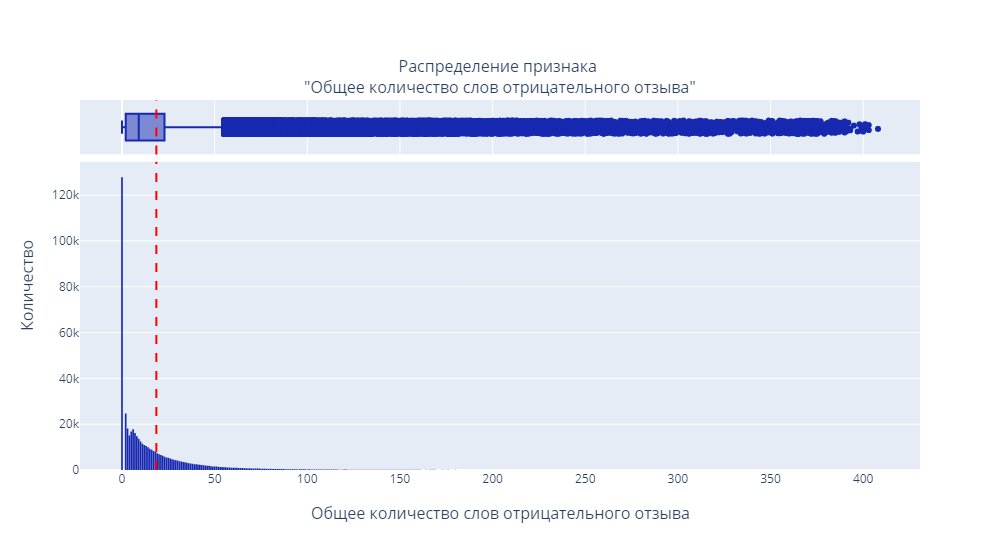

Статистические данные признака:


count    515431.00
mean         18.54
std          29.69
min           0.00
25%           2.00
50%           9.00
75%          23.00
max         408.00
Name: review_total_negative_word_counts, dtype: float64

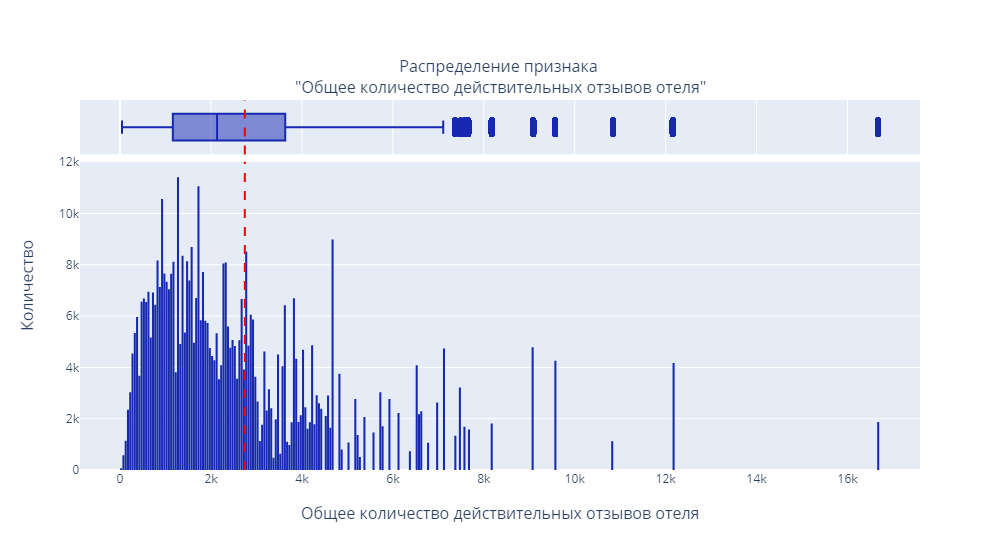

Статистические данные признака:


count    515431.00
mean       2744.26
std        2317.82
min          43.00
25%        1161.00
50%        2134.00
75%        3633.00
max       16670.00
Name: total_number_of_reviews, dtype: float64

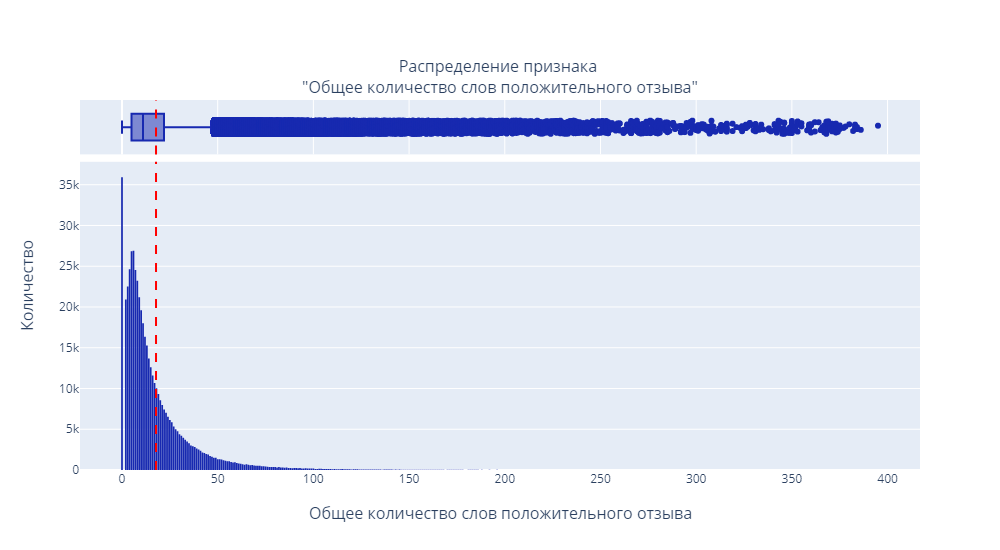

Статистические данные признака:


count    515431.00
mean         17.78
std          21.80
min           0.00
25%           5.00
50%          11.00
75%          22.00
max         395.00
Name: review_total_positive_word_counts, dtype: float64

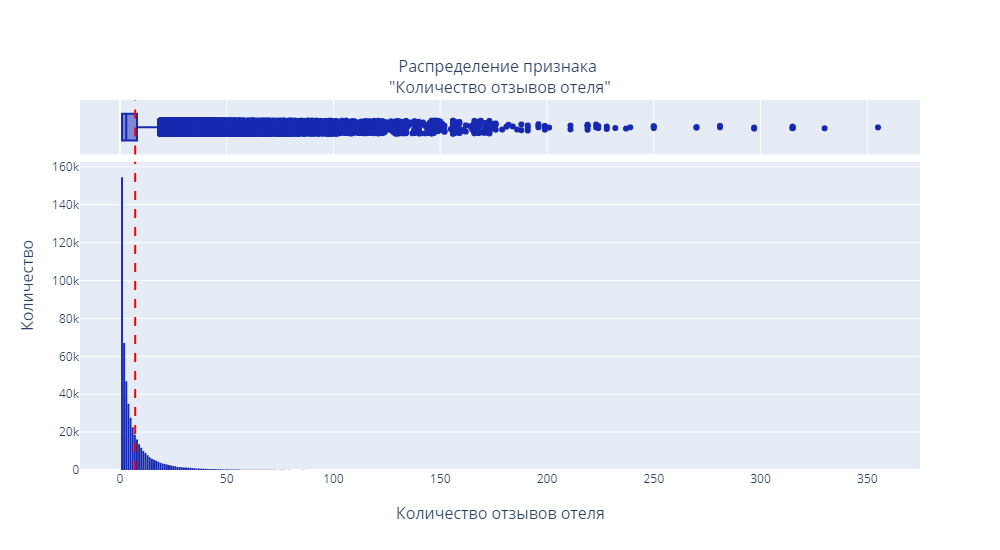

Статистические данные признака:


count    515431.00
mean          7.17
std          11.04
min           1.00
25%           1.00
50%           3.00
75%           8.00
max         355.00
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

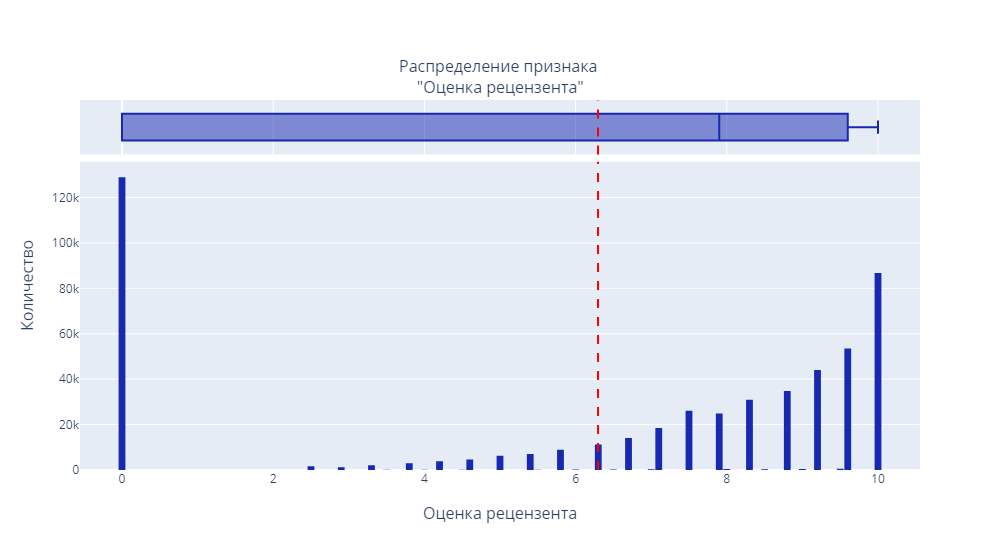

Статистические данные признака:


count    515431.0
mean          6.3
std           3.9
min           0.0
25%           0.0
50%           7.9
75%           9.6
max          10.0
Name: reviewer_score, dtype: float64

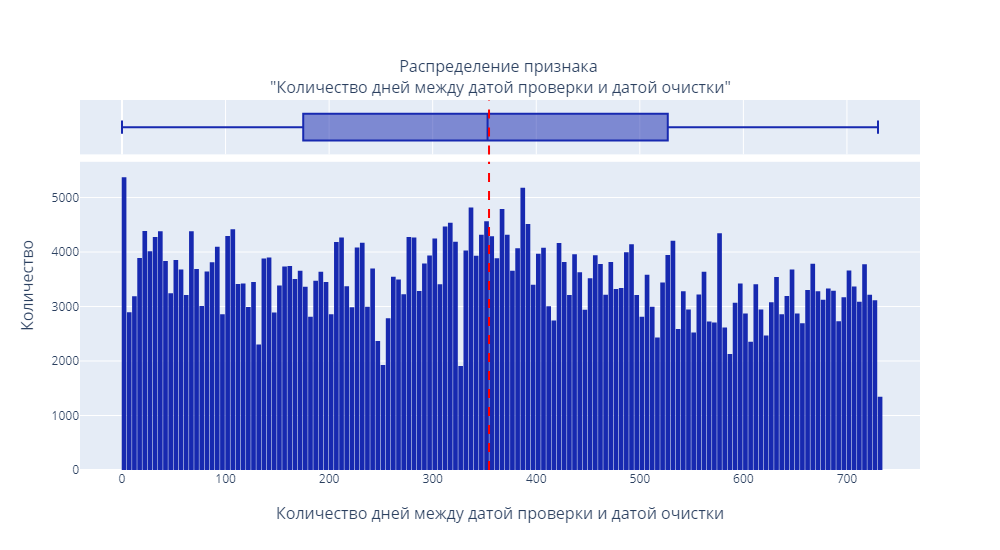

Статистические данные признака:


count    515431.00
mean        354.41
std         208.92
min           0.00
25%         175.00
50%         353.00
75%         527.00
max         730.00
Name: days_since_review, dtype: float64

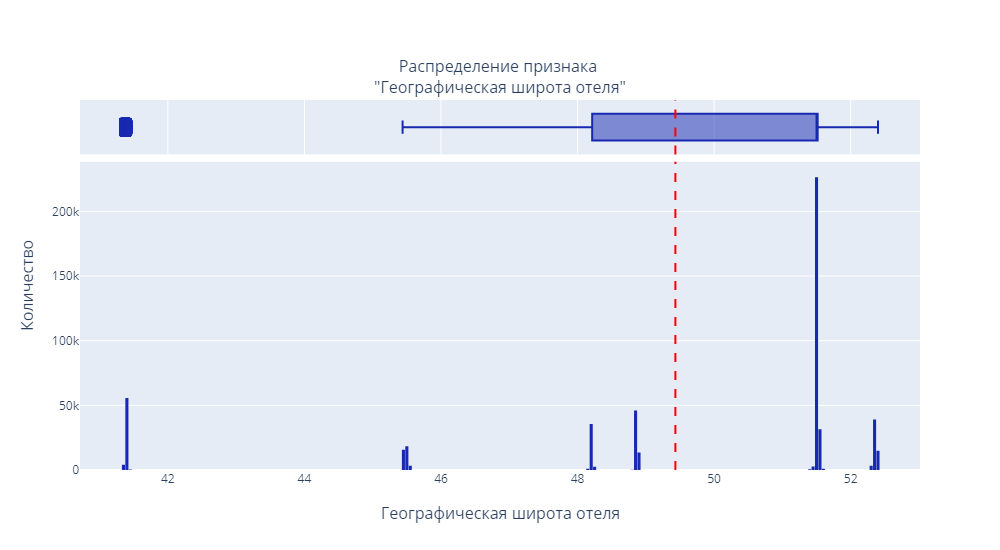

Статистические данные признака:


count    515431.00
mean         49.43
std           3.46
min          41.33
25%          48.21
50%          51.50
75%          51.52
max          52.40
Name: lat, dtype: float64

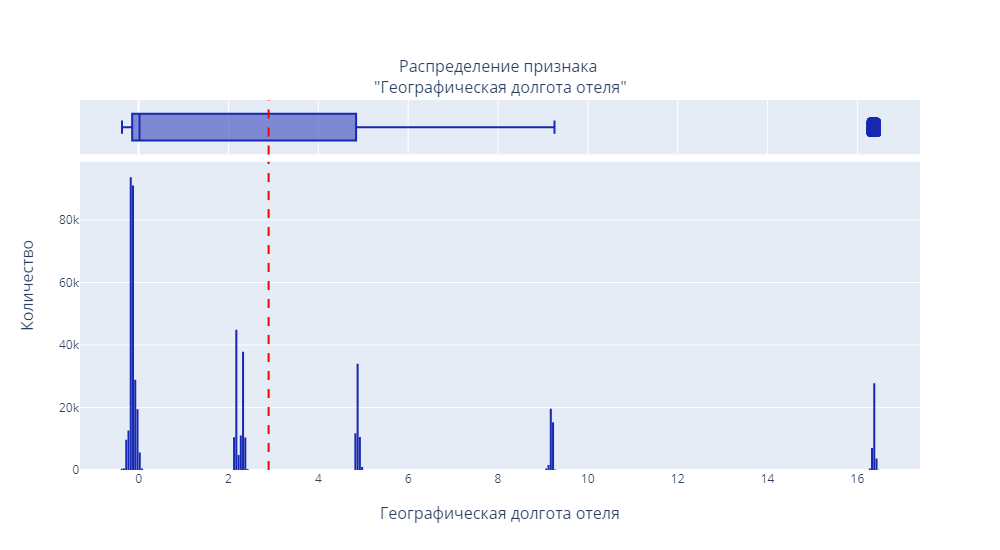

Статистические данные признака:


count    515431.00
mean          2.89
std           4.67
min          -0.37
25%          -0.14
50%           0.02
75%           4.84
max          16.46
Name: lng, dtype: float64

In [14]:
# Построение гистограммы распределения каждого числового признака
for col in list_num_sign:
    plot_numerical_feature(df_hotels, col, dict_col_name_rus[col])

**Количество действительных оценок без проверки**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 498.08;
- медиана 341;
- признак распределен в пределах от 1 до 2682.

**Средний балл отеля за последний год**:
- распределение близко к ***нормальному***;
- среднее значение 8.4;
- медиана 8.4;
- признак распределен в пределах от 5.2 до 9.8.

**Общее количество слов отрицательного отзыва**:
- распределение *ненормальное* (экспоненциальное с разрывом);
- среднее значение 18.54;
- медиана 9;
- признак распределен в пределах от 0 до 408.

**Общее количество действительных отзывов отеля**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 2744.26;
- медиана 2134;
- признак распределен в пределах от 43 до 16670.

**Общее количество слов положительного отзыва**:
- распределение *ненормальное* (при отсечке 0-го значения, отсеченного от основного распределения, приближено к пуассоновскому);
- среднее значение 17.78;
- медиана 11;
- признак распределен в пределах от 0 до 395.

**Количество отзывов отеля**:
- распределение *ненормальное* (приближено к экспоненциальному);
- среднее значение 7.17;
- медиана 3;
- признак распределен в пределах от 1 до 355.

**Оценка рецензента** (без тестовых данных):
- распределение *ненормальное* с множественными пиками (приближено к экспоненциальному со сдвигом);
- среднее значение 8.4;
- медиана 8.8;
- признак распределен в пределах от 2.5 до 10.

**Количество дней между датой проверки и датой очистки**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 354.41;
- медиана 353;
- признак распределен в пределах от 0 до 730.

**Географическая широта отеля**:
- распределение *ненормальное*, разбитое на шесть групп;
- среднее значение 49.43;
- медиана 51.50;
- признак распределен в пределах от 41.33 до 52.40.

**Географическая долгота отеля**:
- распределение *ненормальное*, разбитое на пять групп;
- среднее значение 2.89;
- медиана 0.02;
- признак распределен в пределах от -0.37 до 16.46.

#### Категориальные признаки

Обзор статистики категориальных признаков.

In [15]:
def plot_categorical_feature(data: pd.DataFrame, col: str, main_title: str):
    ''' Функция отрисовывает бары распределения и выводит статистические
    данные категориального признака. Количество баров ограничено 70, 
    длина подписи значений оси - 15 символов.
    Args:
        data (pd.DataFrame): датасет
        col (str): наименование признака
        main_title (str): расшифровка наименования признака для вывода
            в титуле графика
    Returns:
        None
    '''
    # Подготовка данных
    count_bar = 70
    len_xtext = 15
    df_tmp = data[col].value_counts().reset_index()
    df_tmp[col] = df_tmp[col].apply(lambda x: x[:len_xtext]+'...' if len(str(x)) > len_xtext else x)
    # Инициализация полотна
    fig_col = go.Figure(data=go.Bar(x=df_tmp[col].head(count_bar).index,
                                    y=df_tmp['count'].head(count_bar)))
    
    # Размер полотна
    fig_col.update_layout(autosize = False, width = 1000, height = 500)
    # Заголовок диаграммы
    fig_col.update_layout(title=f"Распределение признака <br>\"{main_title}\"",
                          title_x=0.5, # Расположение посередине
                          xaxis_title=main_title, # Подпись Х
                          yaxis_title='Количество', # Подпись Y
                          xaxis=dict(tickvals=df_tmp[col].head(count_bar).index, # Оригинальные значения для оси X
                                     ticktext=df_tmp[col].head(count_bar))) # Новые подписи для оси X                   
    fig_col.show('png')
    
    print('Статистические данные признака:')
    display(data[col].describe())
    print('Top-10 значений (%):')
    display(data[col].value_counts(normalize=True).head(10).round(4)*100)

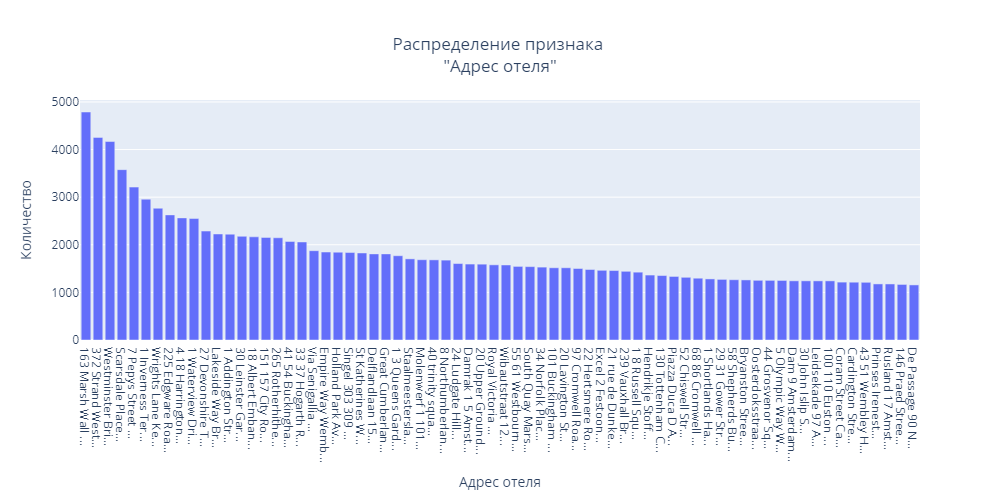

Статистические данные признака:


count                                                515431
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   4789
Name: hotel_address, dtype: object

Top-10 значений (%):


hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              0.93
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     0.83
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     0.81
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    0.69
7 Pepys Street City of London London EC3N 4AF United Kingdom                      0.62
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              0.57
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  0.54
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 0.51
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      0.50
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        0.49
Name: proportion, dtype: float64

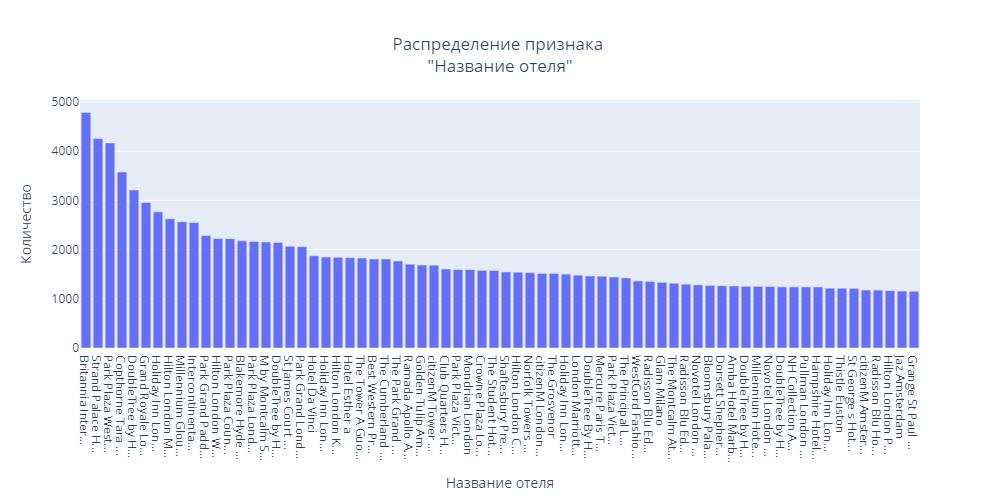

Статистические данные признака:


count                                         515431
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: hotel_name, dtype: object

Top-10 значений (%):


hotel_name
Britannia International Hotel Canary Wharf           0.93
Strand Palace Hotel                                  0.83
Park Plaza Westminster Bridge London                 0.81
Copthorne Tara Hotel London Kensington               0.69
DoubleTree by Hilton Hotel London Tower of London    0.62
Grand Royale London Hyde Park                        0.57
Holiday Inn London Kensington                        0.54
Hilton London Metropole                              0.51
Millennium Gloucester Hotel London                   0.50
Intercontinental London The O2                       0.49
Name: proportion, dtype: float64

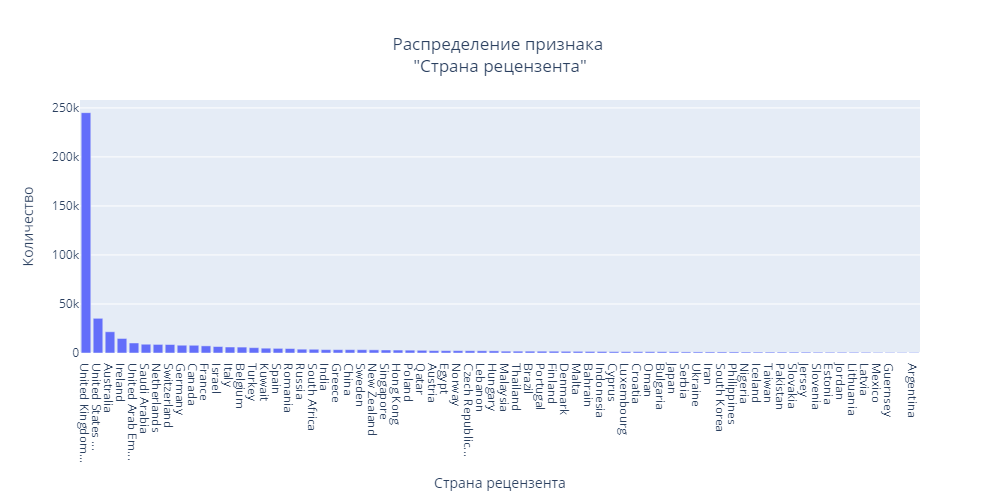

Статистические данные признака:


count               515431
unique                 227
top        United Kingdom 
freq                245165
Name: reviewer_nationality, dtype: object

Top-10 значений (%):


reviewer_nationality
United Kingdom               47.57
United States of America      6.87
Australia                     4.20
Ireland                       2.88
United Arab Emirates          1.98
Saudi Arabia                  1.74
Netherlands                   1.70
Switzerland                   1.68
Germany                       1.54
Canada                        1.53
Name: proportion, dtype: float64

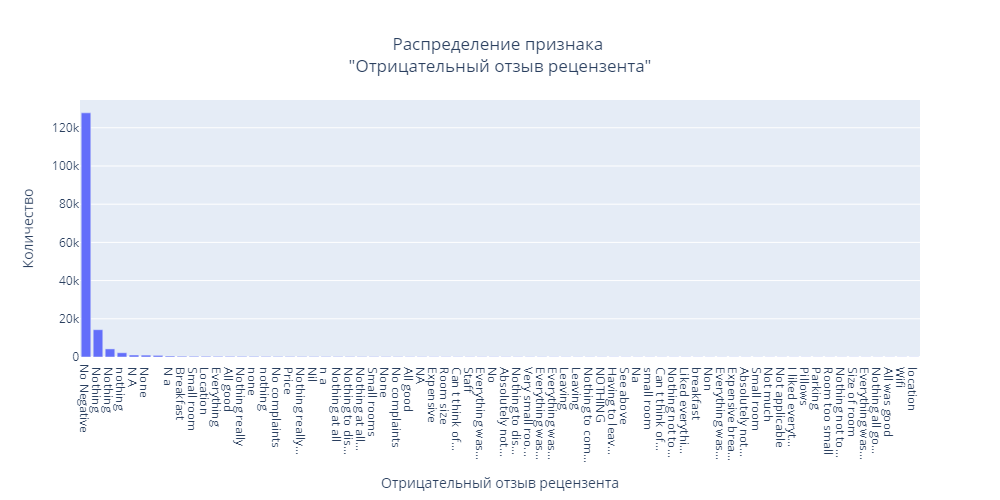

Статистические данные признака:


count          515431
unique         330011
top       No Negative
freq           127816
Name: negative_review, dtype: object

Top-10 значений (%):


negative_review
No Negative    24.80
 Nothing        2.77
 Nothing        0.82
 nothing        0.43
 N A            0.20
 None           0.19
                0.16
 N a            0.10
 Breakfast      0.08
 Small room     0.07
Name: proportion, dtype: float64

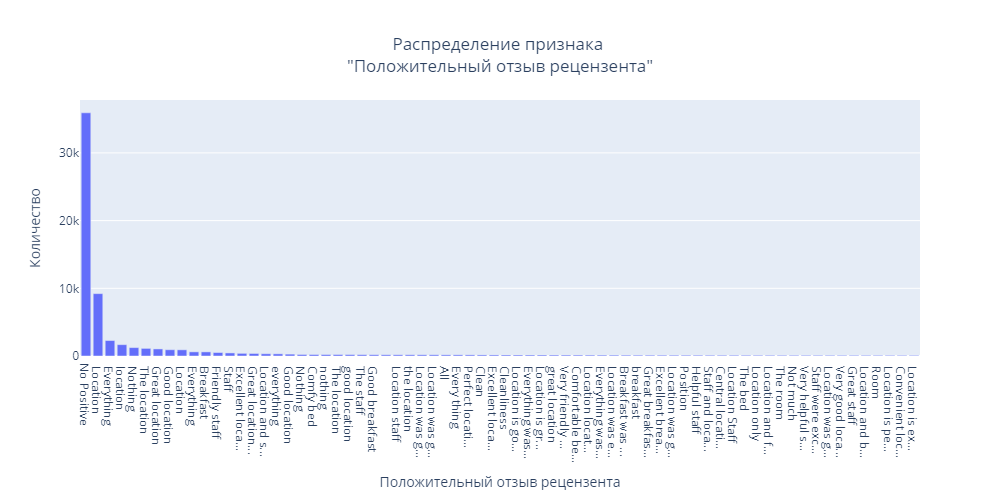

Статистические данные признака:


count          515431
unique         412601
top       No Positive
freq            35924
Name: positive_review, dtype: object

Top-10 значений (%):


positive_review
No Positive        6.97
 Location          1.79
 Everything        0.44
 location          0.32
 Nothing           0.24
 The location      0.22
 Great location    0.20
 Good location     0.18
 Location          0.18
 Everything        0.12
Name: proportion, dtype: float64

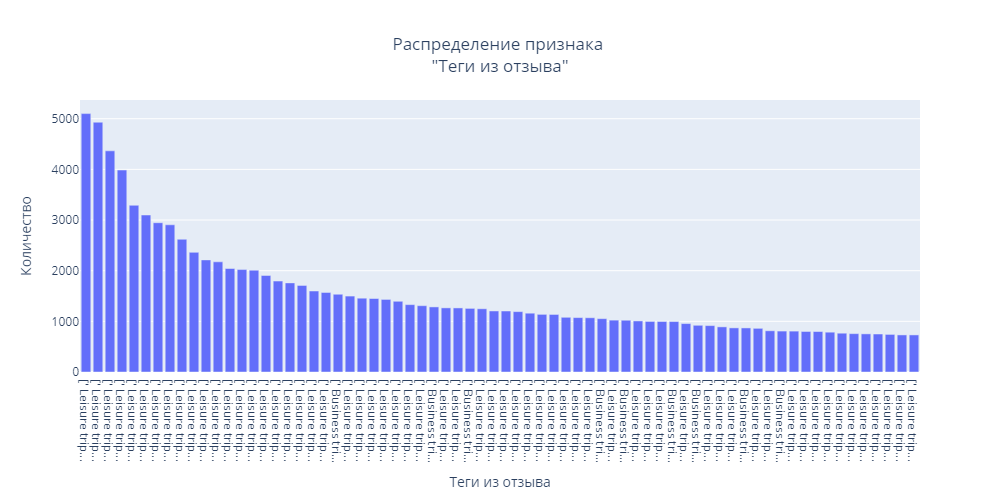

Статистические данные признака:


count                                                515431
unique                                                55242
top       [' Leisure trip ', ' Couple ', ' Double Room '...
freq                                                   5101
Name: tags, dtype: object

Top-10 значений (%):


tags
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              0.99
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     0.96
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     0.85
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       0.77
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             0.64
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    0.60
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    0.57
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  0.56
[' Leisure trip ', 

In [16]:
# Построение баров распределения каждого категориального признака
for col in list_str_sign:
    plot_categorical_feature(df_hotels, col, dict_col_name_rus[col])

Признаки **Адрес отеля** (1493 уникальных значения) и **Название отеля** (1494 уникальных значения) сходны и в совокупности идентифицируют исследуемые объекты. При этом среди них выявлено расхождение, рассмотрим его подробнее ниже.  

**Страна рецензента** содержит 225 уникальных значений, United Kingdom - мода распределения (47.59% записей).  

**Отрицательный отзыв рецензента** содержит 248828 уникальных значений, No Negative - мода распределения (24.8% записей), при этом в признаке присутствуют другие значения, сходные с модой по смыслу.  

**Положительный отзыв рецензента** содержит 311737 уникальных значений, No Positive - мода распределения (6.95% записей), при этом в признаке присутствуют другие значения, сходные с модой по смыслу.  

Признак **Теги отзыва** содержит 47135 уникальных значений, при этом даже мода включает в себя только 1% записей, по своей структуре требует дополнительного анализа преобразования.

#### Признаки в формате даты и времени

In [17]:
print(f'Статистические данные признака "{dict_col_name_rus["review_date"]}":')
display(df_hotels['review_date'].describe())
print('Top-5 значений (%):')
display(df_hotels['review_date'].value_counts(normalize=True).head(5).round(4)*100)

Статистические данные признака "Дата отзыва":


count                           515431
mean     2016-08-13 14:16:05.515849472
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

Top-5 значений (%):


review_date
2017-08-02    0.50
2016-09-15    0.45
2017-04-05    0.44
2016-08-30    0.38
2016-02-16    0.38
Name: proportion, dtype: float64

Признак **Дата отзыва** распределен в пределах от 2015-08-04 до 2017-08-03, выборка включает в себя отзывы за два года.

### Отбор неинформативных признаков

In [18]:
low_information_sign = []
for col in list_str_sign:
    top_freq = df_hotels[col].value_counts(normalize=True).max()
    nunique_ratio = df_hotels[col].nunique()/df_hotels[col].count()
    if top_freq > 0.95:
        low_information_sign.append(col)
        print(f'В признаке "{dict_col_name_rus[col]}" одно уникальное значение')
    if nunique_ratio > 0.95:
        low_information_sign.append(col)
        print(f'В признаке "{dict_col_name_rus[col]}" большинство значений уникальны')
if len(low_information_sign) == 0:
    print('Неинформативные признаки отсутствуют')

Неинформативные признаки отсутствуют


Полностью неинформативные признаки отсутствуют.

### Очистка от выбросов

При очистке от выбросов необходимо исключить от очистки данные из тестовой выборки.

In [19]:
def outliers_z_score_mod(data: pd.DataFrame,
                         feature: str, 
                         log_scale=False,
                         left=3,
                         right=3):
    ''' Функция распределяет строки данных на выбросы и данные, очищенные 
    от выбросов по указанному признаку.
    Args:
        data (pd.DataFrame): датасет
        feature (str): наименование признака, по которому очищается датасет
        log_scale (bool): логирование данных признака
        left (float): коэффициент сигма для очистки данных слева
        right (float): коэффициент сигма для очистки данных справа        
    Returns:
        (pd.DataFrame, pd.DataFrame): кортеж датасетов (выбросы, очищенные данные)
    '''
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    mask_test = data['is_test_dataset'] # Исключаем из очистки тестовые данные
    outliers = data[((x < lower_bound) | (x > upper_bound)) & ~mask_test]
    cleaned = data[((x >= lower_bound) & (x <= upper_bound)) | mask_test]
    return outliers, cleaned


_, df_hotels = outliers_z_score_mod(df_hotels, 'additional_number_of_scoring', 
                                    log_scale=True, left=3, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'average_score', 
                                    log_scale=False, left=3, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_negative_word_counts', 
                                    log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews', 
                                    log_scale=True, left=3, right=3)
_, df_hotels = outliers_z_score_mod(df_hotels, 'review_total_positive_word_counts', 
                                    log_scale=True, left=3, right=3.5)
_, df_hotels = outliers_z_score_mod(df_hotels, 'total_number_of_reviews_reviewer_has_given', 
                                    log_scale=True, left=3, right=3.5)

print(f'Результирующее число записей: {df_hotels.shape[0]}')

Результирующее число записей: 511206


После очистки данных от выбросов в датасете остается 511206 записей.

## Преобразование и генерация признаков

### Признаки "Название отеля" и "Адрес отеля"

В данных о наименовании отелей и их адресах выявлено расхождение, рассмотрим его подробнее.

In [20]:
# Вычисление несоответствия
df_tmp = df_hotels[['hotel_name', 'hotel_address']].copy()
df_tmp.drop_duplicates(inplace=True)
display(df_tmp['hotel_name'].value_counts(sort=True).head(5))
display(df_tmp['hotel_address'].value_counts(sort=True).head(5))

hotel_name
Hotel Regina                 3
The May Fair Hotel           1
Le Belmont Champs Elys es    1
The Beaumont Hotel           1
Novotel London City South    1
Name: count, dtype: int64

hotel_address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom                 2
Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom                  1
5 bis rue Massenet 16th arr 75016 Paris France                                             1
8 Balderton Street Brown Hart Gardens Westminster Borough London W1K 6TF United Kingdom    1
53 61 Southwark Bridge Road Southwark London SE1 9HH United Kingdom                        1
Name: count, dtype: int64

В датасете имеются наименования отелей с одним адресом и несколько отелей с разными адресами и одинаковым названием.

In [21]:
print(df_tmp[df_tmp['hotel_name'] == 'Hotel Regina'].to_string())
print(df_tmp[df_tmp['hotel_address'] == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'].to_string())

        hotel_name                                               hotel_address
479   Hotel Regina                  Bergara 2 4 Eixample 08002 Barcelona Spain
1428  Hotel Regina         Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria
1566  Hotel Regina  Via Cesare Correnti 13 Milan City Center 20123 Milan Italy
                               hotel_name                                                               hotel_address
451         The Grand at Trafalgar Square  8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom
868  Club Quarters Hotel Trafalgar Square  8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom


Так как несколько отелей могут находиться по одному адресу, а также встречаются отели с одинаковым названием, но в разных городах и странах целесообразно из адреса отеля выделить страну и город как отдельные признаки, а также для однозначной идентификации отеля создать идентификационный признак, объединив название отеля, страну и город, исходные признаки удалить. Признак города представить в формате Страна_город для однозначной идентификации городов.

In [22]:
# Получение полного списка стран
url = 'https://textlists.info/geography/countries-of-the-world/'
response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
countries_all = str(page.find('pre').text).strip().split('\r\n')
print(countries_all)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Republic of the', 'Congo, Democratic Republic of the', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor (Timor-Leste)', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India'

В адресах отелей страна указывается последней, перед ней город, но в адресах United Kingdom между ними фигурирует индекс, удаляем его через регулярное выражение.

In [23]:
# Извлечение из адреса отеля страны и города
def get_country_city(address: str):
    ''' Функция возвращает строку в формате "страна, город",
        извлеченную из полного адреса.
    Args:
        address (str): Полный адрес.
    Returns:
        str: Строка в формате "страна, город", если извлечь
             эти данные не удается, возвращает "unknown, unknown".
    '''
    reg = r'\b([A-Z]{1,2}\d[A-Z\d]? \d[A-Z]{2})\b'
    address = re.sub(reg, '', address)
    country = None
    city = None
    address = address.strip()
    for cntr in countries_all:
        if address.endswith(cntr):
            country = cntr
            city = address[:-len(cntr)].split()[-1]
            return country + ', ' + city
    return 'unknown, unknown'


# Создание признаков страны, города, преобразование имени отеля
df_hotels['country_city'] = df_hotels['hotel_address'].apply(get_country_city)
df_hotels['country'] = df_hotels['country_city'].apply(lambda x: x.split(', ')[0])
df_hotels['hotel_name'] = df_hotels['hotel_name'] + ' (' + df_hotels['country_city'] + ')'

In [24]:
# Получение количества записей с нераспознанными страной/городом
print(f"Нераспознанных стран: {df_hotels[df_hotels['country'] == 'unknown'].shape[0]}")
print(f"Нераспознанных стран_городов: {df_hotels[df_hotels['country_city'].str.contains('unknown')].shape[0]}")

Нераспознанных стран: 0
Нераспознанных стран_городов: 0


In [25]:
print(df_hotels[['hotel_name', 'country', 'country_city']].describe())

                                               hotel_name         country  \
count                                              511206          511206   
unique                                               1494               6   
top     Britannia International Hotel Canary Wharf (Un...  United Kingdom   
freq                                                 4789          260082   

                  country_city  
count                   511206  
unique                       6  
top     United Kingdom, London  
freq                    260082  


In [26]:
display(df_hotels[['country', 'country_city']].value_counts())

country         country_city          
United Kingdom  United Kingdom, London    260082
Spain           Spain, Barcelona           59955
France          France, Paris              58389
Netherlands     Netherlands, Amsterdam     56956
Austria         Austria, Vienna            38808
Italy           Italy, Milan               37016
Name: count, dtype: int64

В датасете представлены данные из шести городов шести разных стран, из результирующей тренировочной выборки один из признаков можно исключить.

#### Признаки "Широта" и "Долгота"

Одним из признаков, влияющих на оценку отеля может быть его расположение относительно центра. В связи с этим сгенерируем признак "Расстояние до центра" (distance_to_center)

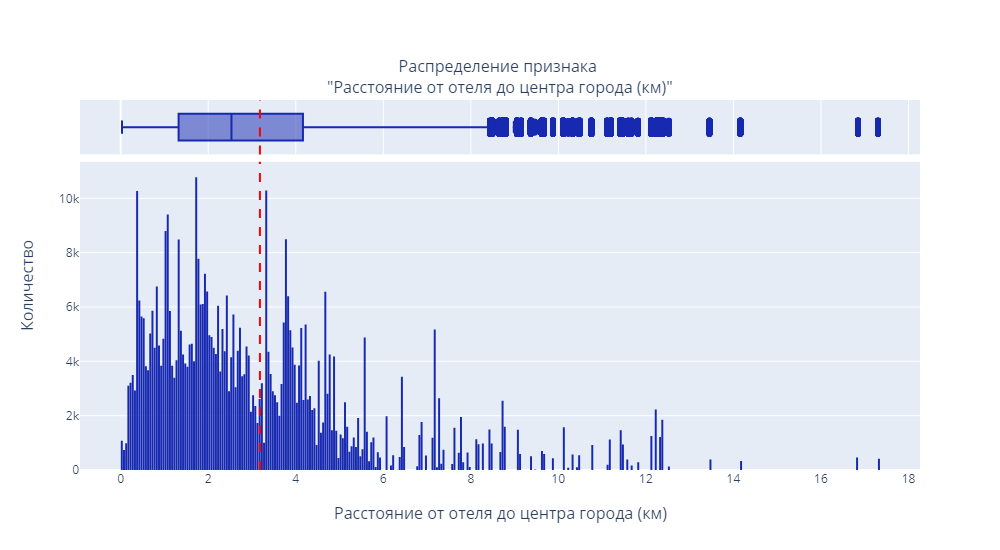

Статистические данные признака:


count    511206.00
mean          3.18
std           2.58
min           0.03
25%           1.32
50%           2.53
75%           4.16
max          17.30
Name: distance_to_center, dtype: float64

In [27]:
# Словарь координат центра по городам
dict_city_center = {'United Kingdom, London': (51.5085, -0.12574),
                    'Spain, Barcelona': (41.38879, 2.15899),
                    'France, Paris': (48.8534, 2.3488),
                    'Netherlands, Amsterdam': (52.3747,  4.8986),
                    'Austria, Vienna': (48.2085, 16.3721),
                    'Italy, Milan': (45.4643, 9.18951)}
df_hotels['distance_to_center'] = df_hotels.apply(lambda x: geodesic((x['lat'], x['lng']), dict_city_center[x['country_city']]).kilometers, axis=1)
plot_numerical_feature(df_hotels, 'distance_to_center', 'Расстояние от отеля до центра города (км)')

**Расстояние от отеля до центра города (км)**:
- распределение *ненормальное* с множественными пиками;
- среднее значение 3.18;
- медиана 2.53;
- признак распределен в пределах от 0.03 до 17.3

#### Признак "Страна рецензента"

При рассмотрении страны рецензента мы можем сравнить ее со страной отеля и вывести признак **Зарубежный гость** ('foreign_guest'). Также разделим посетителей по религиозному признаку по пяти основным течениям (Христианство, Ислам, Иудаизм, Буддизм, Индуизм), основываясь на преобладающей религии страны.

In [28]:
# Формирование признака Зарубежный гость
df_hotels['reviewer_nationality'] = df_hotels['reviewer_nationality'].str.strip()
df_hotels['foreign_guest'] = np.where(df_hotels['country'] != df_hotels['reviewer_nationality'], True, False)

In [29]:
def plot_categorical_feature_pie(data: pd.DataFrame, col: str, main_title: str):
    ''' Функция отрисовывает круговую диаграмму категориального признака.
    Args:
        data (pd.DataFrame): датасет
        col (str): наименование признака
        main_title (str): расшифровка наименования признака для вывода
            в титуле графика
    Returns:
        None
    '''
    # Построение круговой диаграммы
    fig = go.Figure(data=[go.Pie(labels=data[col].value_counts().index,
                                 values=data[col].value_counts())])
    # Стиль отображения
    fig.update_traces(textinfo='label+percent+value', # Содержимое подписи
                      textfont_size=14, # Размер шрифта подписи
                      pull=[0.05, 0.05], # Сдвиг сектора
                      marker=dict(colors=["#FFB740", "#FF2800"]), # Цвета секторов
                      showlegend=False) # Скрыть легенду
    # Размер полотна
    fig.update_layout(autosize = False, width = 600, height = 600)
    # Заголовок диаграммы
    fig.update_layout(title=main_title,
                      title_x=0.5) # Расположение посередине
    fig.show("png")

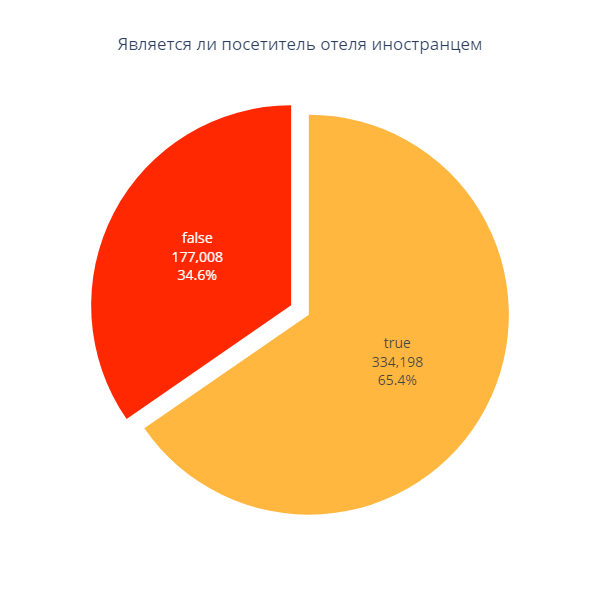

In [30]:
plot_categorical_feature_pie(df_hotels, 'foreign_guest', 'Является ли посетитель отеля иностранцем')

Полученные значения показывают, что 65.4% отзывов получены от зарубежных гостей.

In [31]:
# Списки стран основных религий
country_christianity = ['American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua and Barbuda', 
                        'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'The Bahamas', 
                        'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bolivia', 
                        'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 
                        'Bulgaria', 'Burundi', 'Cape Verde', 'Cameroon', 'Canada', 'Cayman Islands', 
                        'Chile', 'Colombia', 'Cook Islands', 'Costa Rica', 'Croatia', 
                        'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'DR Congo', 'Denmark', 'Dominica', 
                        'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 
                        'Eritrea', 'Estonia', 'Ethiopia', 'The Falkland Islands', 'Faroe Islands', 
                        'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Georgia', 
                        'Germany', 'Ghana', 'Greece', 'Greenland', 'Grenada', 'Guatemala', 'Guyana', 
                        'Haiti', 'The Vatican', 'Honduras', 'Hungary', 'Iceland', 'Ireland', 'Italy', 
                        'Jamaica', 'Kenya', 'Kiribati', 'Latvia', 'Lesotho', 'Liberia', 'Liechtenstein', 
                        'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malta', 'Marshall Islands', 
                        'Mexico', 'Micronesia', 'Monaco', 'Montenegro', 'Mozambique', 'Namibia', 'Nauru', 
                        'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Nigeria', 'Niue', 
                        'Northern Mariana Islands', 'Norway', 'Palau', 'Panama', 'Papua New Guinea', 
                        'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 
                        'Russia', 'Rwanda', 'Islands of Saint Helena, Ascension and Tristan da Cunha', 
                        'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Pierre and Miquelon', 
                        'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 
                        'Serbia', 'Seychelles', 'Sint Maarten', 'Slovakia', 'Slovenia', 'Solomon Islands', 
                        'South Africa', 'South Sudan', 'Spain', 'Suriname', 'Sweden', 'Switzerland', 
                        'East Timor', 'That', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tuvalu', 'Uganda',
                        'Ukraine', 'United Kingdom', 'Tanzania', 'United States Virgin Islands', 'United States of America', 
                        'Uruguay', 'Vanuatu', 'Venezuela', 'Wallis and Futuna', 'Zambia', 'Zimbabwe', 'Jersey',
                        'Guernsey', 'Isle of Man', 'Gibraltar', 'Macedonia', 'Abkhazia Georgia', 'Moldova',
                        'United States Minor Outlying Islands', 'Bahamas', 'U S Virgin Islands', 'Turks Caicos Islands',
                        'Antigua Barbuda', 'Guam', 'St Maarten', 'Democratic Republic of the Congo', 'Swaziland',
                        'Reunion', 'Falkland Islands Malvinas', 'Crimea', 'Martinique', 'Guadeloupe', 
                        'Saint Martin', 'French Guiana', 'Bonaire St Eustatius and Saba', 'Congo', 
                        'Central Africa Republic', 'Saint Barts', 'Antarctica', 'Saint Vincent Grenadines',
                        'Montserrat', 'St Pierre and Miquelon', 'Vatican City']
country_islam = ['Afghanistan', 'Albania', 'Algeria', 'Azerbaijan', 
                 'Bahrain', 'Bangladesh', 'Brunei', 'Burkina Faso', 
                 'Chad', 'Djibouti', 'Egypt', 'Gambia', 
                 'Guinea', 'Guinea-Bissau', 'Indonesia', 'Iran', 
                 'Iraq', 'Jordan', 'Kazakhstan', 'Kuwait', 
                 'Kyrgyzstan', 'Lebanon', 'Libya', 'Malaysia', 
                 'Maldives', 'Mali', 'Mauritania', 'Morocco', 
                 'Niger', 'Oman', 'Pakistan', 'Qatar', 
                 'Saudi Arabia', 'Senegal', 'Sierra Leone', 'Somalia', 
                 'Sudan', 'Syria', 'Tajikistan', 'Tunisia', 
                 'Turkey', 'United Arab Emirates', 'Uzbekistan', 'Western Sahara', 
                 'Yemen', 'Palestinian Territory', 'Turkmenistan', 'Comoros']
country_judaism = ['Israel']
country_hinduism = ['India', 'Mauritius', 'Nepal']
country_buddhism = ['Bhutan', 'Cambodia', 'Laos', 'Mongolia', 'Myanmar', 'Singapore', 
                    'Sri Lanka', 'Thailand', 'Japan', 'South Korea', 'Vietnam', 'Macau']

In [32]:
# Формирование признаков
df_hotels['religion_christianity'] = df_hotels['reviewer_nationality'].apply(lambda x: x in country_christianity)
df_hotels['religion_islam'] = df_hotels['reviewer_nationality'].apply(lambda x: x in country_islam)
df_hotels['religion_judaism'] = df_hotels['reviewer_nationality'].apply(lambda x: x in country_judaism)
df_hotels['religion_hinduism'] = df_hotels['reviewer_nationality'].apply(lambda x: x in country_hinduism)
df_hotels['religion_buddhism'] = df_hotels['reviewer_nationality'].apply(lambda x: x in country_buddhism)

In [33]:
print(df_hotels[(df_hotels['religion_christianity'] != True) &
          (df_hotels['religion_islam'] != True) &
          (df_hotels['religion_judaism'] != True) &
          (df_hotels['religion_hinduism'] != True) &
          (df_hotels['religion_buddhism'] != True)]['reviewer_nationality'].value_counts())

reviewer_nationality
China                 3369
Hong Kong             2975
Taiwan                 915
                       518
Kosovo                  70
Cura ao                 41
Ivory Coast             19
Togo                     7
Cocos K I                2
Svalbard Jan Mayen       1
Name: count, dtype: int64


#### Признак "Теги из отзыва"

Данный признак содержит список тегов, прикрепленных посетителем к отзыву и требует преобразования. 
Для выделения в отдельные признаки будем рассматривать теги, которые встречаются более чем в 5% отзывов, так как признак с меньшим количеством значимых элементов можно признать неинформативным.

In [34]:
# Получение полного списка тегов
tags_all = dict()
for tags in df_hotels['tags']:
    for tag in ast.literal_eval(tags):
        if tags_all.get(tag, 0) == 0:
            tags_all[tag] = 1
        else:
            tags_all[tag] = tags_all[tag] + 1
count_rev = df_hotels.shape[0]
tags_all_percent = dict()
for tag in tags_all:
    tags_all_percent[tag] = tags_all[tag] * 100 / count_rev
print(f'Количество уникольных тэгов: {len(tags_all)}')
# Сортируем словарь по значениям
sorted_dict = dict(sorted(tags_all_percent.items(), key=lambda item: item[1], reverse=True))
# Вывод тегов для формирования новых признаков
for tag in sorted_dict:
    if sorted_dict[tag] > 5:
        print(f'"{tag}"')
    else:
        break

Количество уникольных тэгов: 2390
" Leisure trip "
" Submitted from a mobile device "
" Couple "
" Stayed 1 night "
" Stayed 2 nights "
" Solo traveler "
" Stayed 3 nights "
" Business trip "
" Group "
" Family with young children "
" Stayed 4 nights "
" Double Room "
" Standard Double Room "
" Superior Double Room "
" Family with older children "


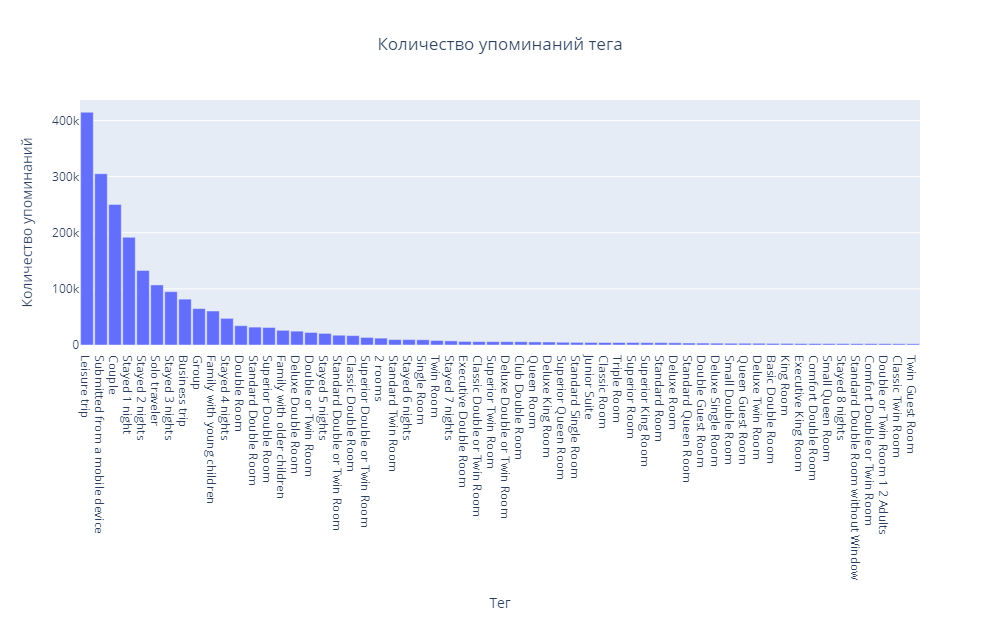

In [35]:
sorted_dict = dict(sorted(tags_all.items(), key=lambda item: item[1], reverse=True)[:60])
# Построение гистограммы
# Распределение категорий признака Требования к опыту
fig_tags = go.Figure(data=go.Bar(x=list(sorted_dict.keys()),
                                 y=list(sorted_dict.values())))
fig_tags.update_layout(autosize = False, width = 1000, height = 620, # Размер полотна
                                bargap=0.1) # Расстояние между столбцами
# Заголовк и подписи осей
fig_tags.update_layout(title='Количество упоминаний тега',
                                title_x=0.5, # Выравнивание заголовка посередине
                                xaxis_title='Тег', # Подпись Х
                                yaxis_title='Количество упоминаний') # Подпись Y
fig_tags.show('png')

В результате изучения состава тегов выделяем следующие признаки:
- Количество тегов отзыва (tags_count)
- Количество проведенных ночей (stayed_nights) - упоминание в контексте *" Stayed DD night(s) "*
- Цель поездки (trip_type): 
    - " Leisure trip "
    - " Business trip "
- Отправлено с мобильного устройства (tag_from_mobile) - упоминание " Submitted from a mobile device "
- Комплект признаков описания комнаты:
    - tag_dbl_room для " Double Room "
    - tag_dbl_room_std для " Standard Double Room "
    - tag_dbl_room_spr для " Superior Double Room "
- Комплект признаков описания состава посетителей:
    - пара (tag_couple) для " Couple "
    - один (tag_solo) для " Solo traveler "
    - группа (tag_group) для " Group "
    - семья с маленькими детьми (tag_fam_young_chldr) для " Family with young children "
    - семья с детьми старшего возраста (tag_fam_older_chldr) для " Family with older children "

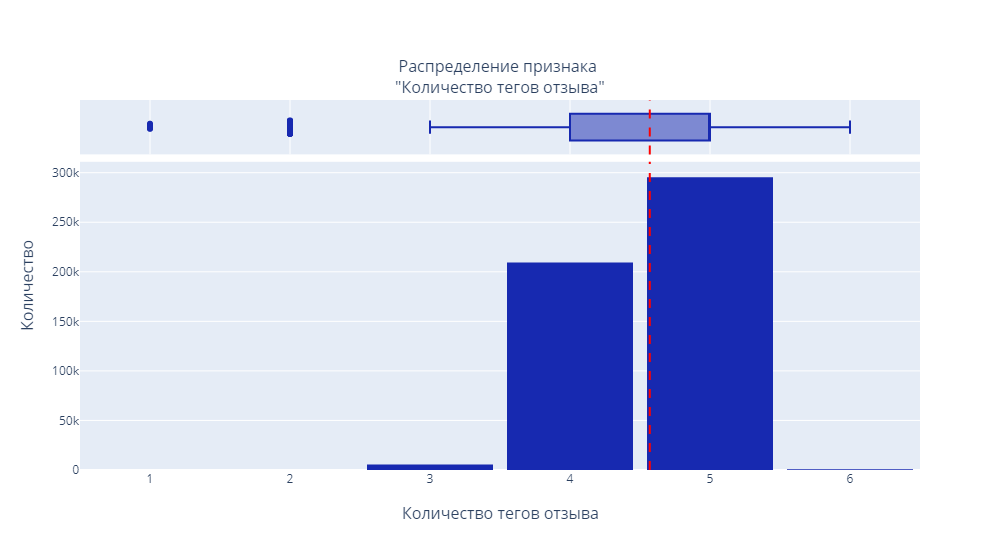

Статистические данные признака:


count    511206.00
mean          4.57
std           0.52
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           6.00
Name: tags_count, dtype: float64

In [36]:
# Генерация tags_count
df_hotels['tags_count'] = df_hotels['tags'].apply(lambda x: len(ast.literal_eval(x)))
plot_numerical_feature(df_hotels, 'tags_count', 'Количество тегов отзыва')

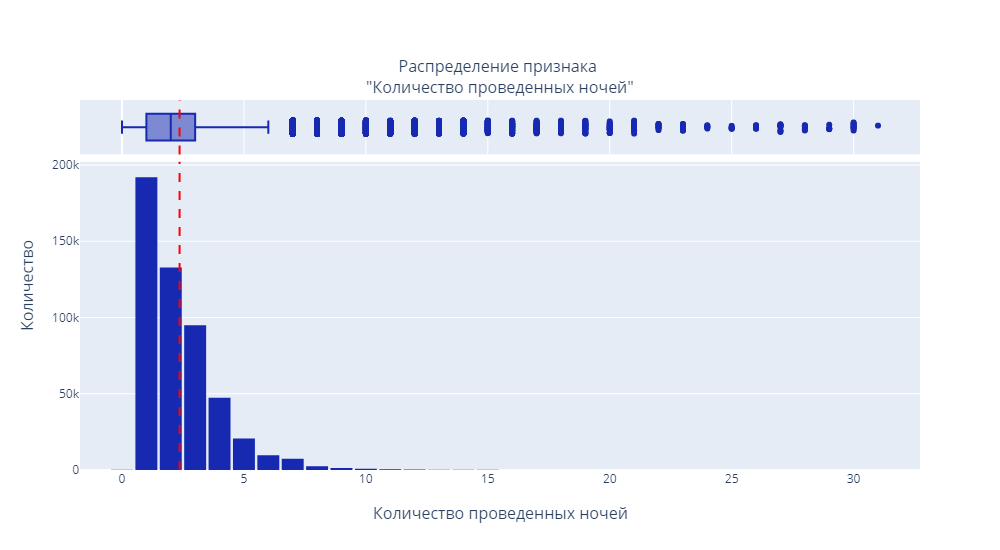

Статистические данные признака:


count    511206.00
mean          2.36
std           1.65
min           0.00
25%           1.00
50%           2.00
75%           3.00
max          31.00
Name: stayed_nights, dtype: float64

In [37]:
# Генерация stayed_nights
def get_stayed_nights(tags: str):
    ''' Функция возвращает из строки тегов количество проведенных ночей.
    Args:
        tags (str): Строка, содержащая все теги
    Returns:
        int: Количество проведенных ночей, если строка не содержит
             регулярных выражений возвращает None
    '''
    reg_SN = r'Stayed (\d+) night'
    match = re.search(reg_SN, tags)
    if match:
        return (int(match.group(1)))
    else:
        return (np.nan)


df_hotels['stayed_nights'] = df_hotels['tags'].apply(get_stayed_nights)
# Заполнение отсутствующих значений модой признака
stayed_nights_mode = df_hotels['stayed_nights'].mode()[0]
df_hotels['stayed_nights'] = df_hotels['stayed_nights'].fillna(0)#stayed_nights_mode)
# Отрисовка
plot_numerical_feature(df_hotels, 'stayed_nights', 'Количество проведенных ночей')

In [38]:
# Генерация trip_type
def get_trip_type(tags: str):
    ''' Функция возвращает из строки тегов цель поездки.
    Args:
        tags (str): Строка, содержащая все теги
    Returns:
        int: Количество проведенных ночей, если строка не содержит
             регулярных выражений возвращает None
    '''
    if 'Business trip' in tags:
        return 'Business'
    elif 'Leisure trip' in tags:
        return 'Leisure'
    else:
        return np.nan


df_hotels['trip_type'] = df_hotels['tags'].apply(get_trip_type)
# Заполнение отсутствующих значений модой признака
trip_type_mode = df_hotels['trip_type'].mode()[0]
df_hotels['trip_type'] = df_hotels['trip_type'].fillna(trip_type_mode)

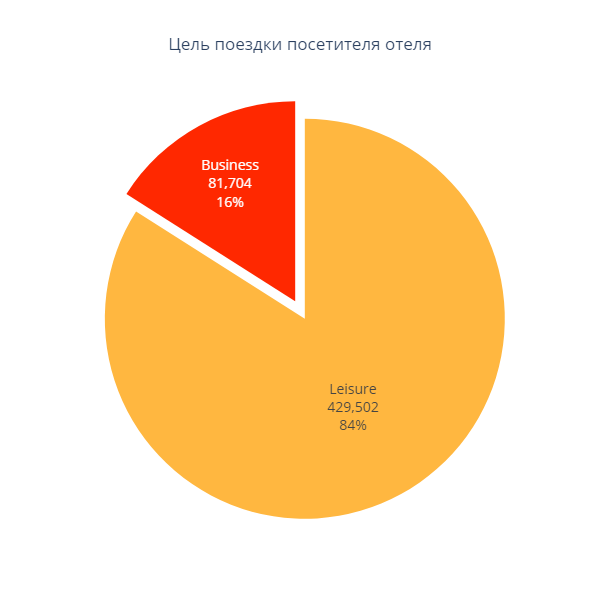

In [39]:
# Построение круговой диаграммы
plot_categorical_feature_pie(df_hotels, 'trip_type', 'Цель поездки посетителя отеля')

**Количество тегов отзыва**:
- распределение *ненормальное*;
- среднее значение 4.57;
- медиана 5;
- признак распределен в пределах от 1 до 6.

**Количество проведенных ночей**:
- распределение *ненормальное* (приближено к экспоненциальному);
- среднее значение 2.36;
- медиана 2;
- признак распределен в пределах от 1 до 30.

**Цель поездки** содержит 2 уникальных значения, Leisure (Туристическая поездка) - мода распределения (84% записей). Преобразуем в признак **Туристическая поездка**.

In [40]:
# Преобразвание признака
df_hotels['is_leisure_trip'] = np.where(df_hotels['trip_type'] == 'Leisure', True, False)
df_hotels.drop(['trip_type'], axis = 1, inplace=True)

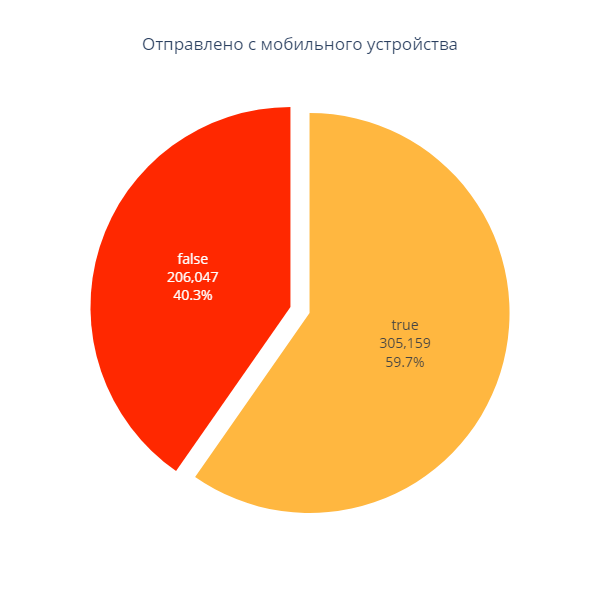

In [41]:
# Генерация признака Отправлено с мобильного устройства
df_hotels['tag_from_mobile'] = df_hotels['tags'].apply(lambda x: ' Submitted from a mobile device ' in x)
# Построение круговой диаграммы
plot_categorical_feature_pie(df_hotels, 'tag_from_mobile', 'Отправлено с мобильного устройства')

Полученные значения показывают, что 59.7% отзывов получены с мобильного устройства.

In [42]:
# Генерация признака " Double Room "
df_hotels['tag_dbl_room'] = df_hotels['tags'].apply(lambda x: "' Double Room '" in x)
# Генерация признака " Standard Double Room "
df_hotels['tag_dbl_room_std'] = df_hotels['tags'].apply(lambda x: ' Standard Double Room ' in x)
# Генерация признака " Superior Double Room "
df_hotels['tag_dbl_room_spr'] = df_hotels['tags'].apply(lambda x: ' Superior Double Room ' in x)
display(df_hotels['tag_dbl_room'].value_counts(normalize=True).round(3))
display(df_hotels['tag_dbl_room_std'].value_counts(normalize=True).round(3))
display(df_hotels['tag_dbl_room_spr'].value_counts(normalize=True).round(3))

tag_dbl_room
False    0.933
True     0.067
Name: proportion, dtype: float64

tag_dbl_room_std
False    0.93
True     0.07
Name: proportion, dtype: float64

tag_dbl_room_spr
False    0.931
True     0.069
Name: proportion, dtype: float64

Каждый из тегов " Double Room ", " Standard Double Room " и " Superior Double Room " встречается ориентировочно в 7% отзывов каждый.

In [43]:
# Комплект признаков описания состава посетителей:
# Генерация признака Пара
df_hotels['tag_couple'] = df_hotels['tags'].apply(lambda x: ' Couple ' in x)
# Генерация признака Один
df_hotels['tag_solo'] = df_hotels['tags'].apply(lambda x: ' Solo traveler ' in x)
# Генерация признака Группа
df_hotels['tag_group'] = df_hotels['tags'].apply(lambda x: ' Group ' in x)
# Генерация признака Семья с маленькими детьми
df_hotels['tag_fam_young_chldr'] = df_hotels['tags'].apply(lambda x: ' Family with young children ' in x)
# Генерация признака Семья с детьми старшего возраста
df_hotels['tag_fam_older_chldr'] = df_hotels['tags'].apply(lambda x: ' Family with older children ' in x)
display(df_hotels['tag_couple'].value_counts(normalize=True).round(3))
display(df_hotels['tag_solo'].value_counts(normalize=True).round(3))
display(df_hotels['tag_group'].value_counts(normalize=True).round(3))
display(df_hotels['tag_fam_young_chldr'].value_counts(normalize=True).round(3))
display(df_hotels['tag_fam_older_chldr'].value_counts(normalize=True).round(3))

tag_couple
False    0.51
True     0.49
Name: proportion, dtype: float64

tag_solo
False    0.791
True     0.209
Name: proportion, dtype: float64

tag_group
False    0.873
True     0.127
Name: proportion, dtype: float64

tag_fam_young_chldr
False    0.882
True     0.118
Name: proportion, dtype: float64

tag_fam_older_chldr
False    0.949
True     0.051
Name: proportion, dtype: float64

Теги " Couple ", " Solo traveler ", " Group ", " Family with young children " и " Family with older children " упоминаются в 49%, 21%, 12.7%, 11.8% и 5% отзывов соответственно.

#### Признак "Отрицательный отзыв рецензента"

Признак преобразуем в **Присутствует отрицательный отзыв** посредством проверки вхождения текста отзыва в список, включающий варианты отсутствия отрицательного отзыва. Отбираем подобные формулировки из 100 наиболее встречающихся. Остальные помечаются как имеющие отрицательный отзыв.

In [44]:
print(df_hotels['negative_review'].value_counts(normalize=True).head(100).index)

Index(['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
       ' ', ' N a', ' Breakfast', ' Small room', ' Location', ' Everything',
       ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints',
       ' Price', ' Nothing really ', ' Nil', ' n a', ' Nothing at all',
       ' Nothing to dislike', ' Nothing at all ', ' Small rooms', ' None ',
       ' No complaints ', ' All good ', ' NA', ' Expensive', ' Room size',
       ' Can t think of anything ', ' Everything was perfect',
       ' Absolutely nothing ', ' No', ' Staff', ' Nothing to dislike ',
       ' Very small room', ' Everything was perfect ',
       ' Everything was great ', ' Leaving', ' Nothing to complain about ',
       ' Leaving ', ' NOTHING', ' Having to leave ', ' See above', ' Na',
       ' small room', ' Can t think of anything', ' Liked everything',
       ' Nothing not to like', ' breakfast', ' Non', ' Everything was great',
       ' Expensive breakfast', ' Absolutely nothing', ' 

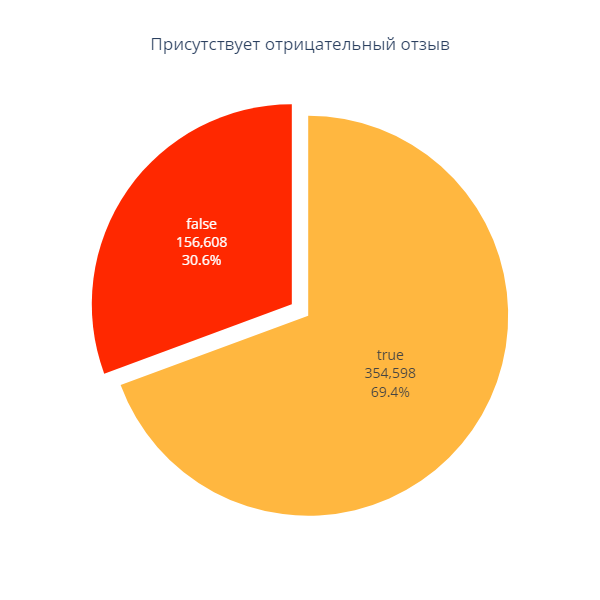

In [45]:
# Список 
list_no_negative_review = ['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
                           ' ', ' N a', ' Nothing really', ' none', ' nothing ', ' No complaints', 
                           ' Nil', ' Nothing really ', ' n a', ' Nothing to dislike', ' Nothing at all', 
                           ' Nothing at all ', ' None ', ' No complaints ', ' All good ', ' NA', 
                           ' Absolutely nothing ', ' Can t think of anything ', ' Everything was perfect', 
                           ' Nothing to dislike ', ' No', ' Everything was great ', ' Everything was perfect ', 
                           ' Nothing to complain about ', ' NOTHING', ' Na', ' Nothing not to like', 
                           ' Everything was great', ' Can t think of anything', ' Liked everything', 
                           ' Non', ' Everything was good', ' All was good', ' Absolutely nothing', 
                           ' I liked everything', ' Nothing not to like ', ' Nothing to complain about', 
                           ' Everything was good ', ' No thing', ' I liked everything ', ' Everything was fine', 
                           ' Nothing in particular', ' nothing really', ' There was nothing I didn t like ']
# Генерация признака
df_hotels['has_negative_review'] = df_hotels['negative_review'].apply(lambda x: not(x in list_no_negative_review))
# Построение круговой диаграммы
plot_categorical_feature_pie(df_hotels, 'has_negative_review', 'Присутствует отрицательный отзыв')

**Присутствует отрицательный отзыв** содержит 2 уникальных значений, True (присутствует) - мода распределения (69,4% записей).

Также с помощью инструмента для анализа тональности текста сгенерируем признак **Сводная оценка отрицательного отзыва** (compound_negative_review).

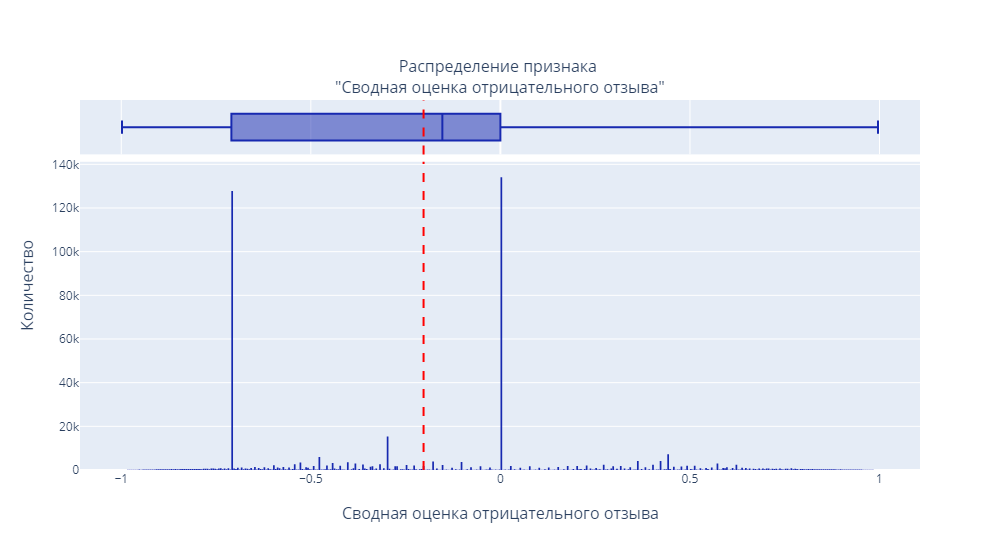

Статистические данные признака:


count    511206.00
mean         -0.20
std           0.46
min          -1.00
25%          -0.71
50%          -0.15
75%           0.00
max           1.00
Name: compound_negative_review, dtype: float64

In [46]:
# Генерация Сводной оценки отрицательного отзыва
sia = SentimentIntensityAnalyzer()
df_hotels['compound_negative_review'] = df_hotels['negative_review'].apply(lambda x: sia.polarity_scores(x)['compound'])
plot_numerical_feature(df_hotels, 'compound_negative_review', 'Сводная оценка отрицательного отзыва')

#### Признак "Положительный отзыв рецензента"

Признак преобразуем в **Присутствует положительный отзыв** посредством проверки вхождения текста отзыва в список, включающий варианты отсутствия положительного отзыва. Отбираем подобные формулировки из 100 наиболее встречающихся. Остальные помечаются как имеющие положительный отзыв.

In [47]:
print(df_hotels['positive_review'].value_counts(normalize=True).head(100).index)

Index(['No Positive', ' Location', ' Everything', ' location', ' Nothing',
       ' The location', ' Great location', ' Good location', ' Location ',
       ' Everything ', ' Breakfast', ' Friendly staff', ' Staff',
       ' Excellent location', ' Great location ', ' Location and staff',
       ' everything', ' Good location ', ' Comfy bed', ' The location ',
       ' Nothing ', ' nothing', ' good location', ' The staff',
       ' Good breakfast', ' ', ' Location was good', ' Location was great',
       ' the location', ' Location staff', ' All', ' Every thing',
       ' Perfect location', ' Clean', ' Excellent location ', ' Cleanliness',
       ' Location is good', ' Everything was perfect', ' Location is great',
       ' great location', ' Very friendly staff', ' Comfortable bed',
       ' Location location location', ' Everything was perfect ',
       ' Location was excellent', ' Breakfast was good',
       ' Excellent breakfast', ' breakfast', ' Great breakfast',
       ' Location 

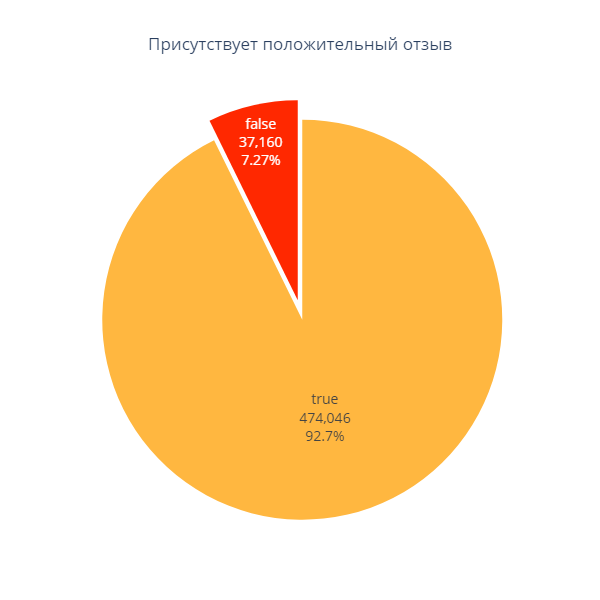

In [48]:
# Список 
list_no_positive_review = ['No Positive', ' Nothing', ' Nothing ', ' nothing']
# Генерация признака
df_hotels['has_positive_review'] = df_hotels['positive_review'].apply(lambda x: not(x in list_no_positive_review))
# Построение круговой диаграммы
plot_categorical_feature_pie(df_hotels, 'has_positive_review', 'Присутствует положительный отзыв')

**Присутствует положительный отзыв** содержит 2 уникальных значения, True (присутствует) - мода распределения (92,7% записей).  

Также с помощью инструмента для анализа тональности текста сгенерируем признак **Сводная оценка положительного отзыва** (compound_positive_review).

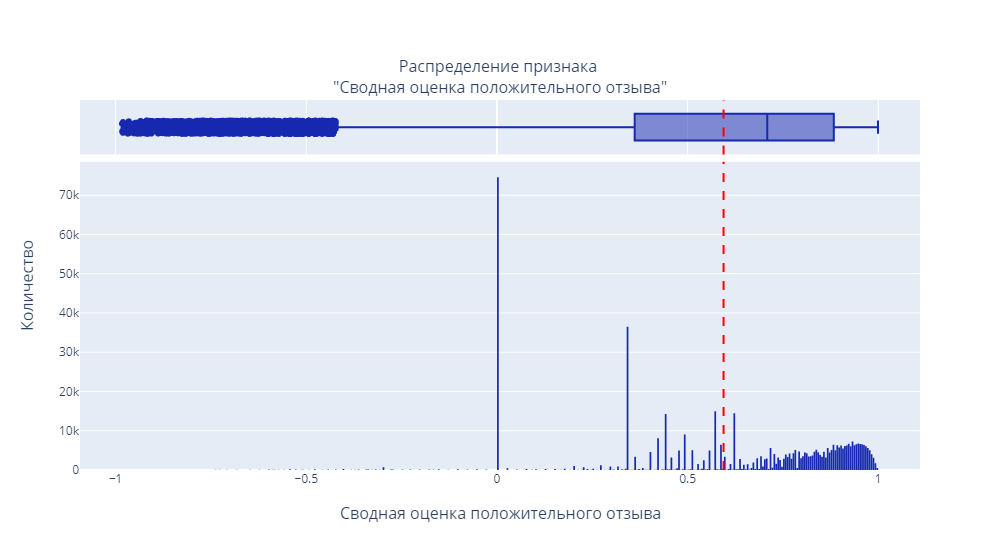

Статистические данные признака:


count    511206.00
mean          0.59
std           0.34
min          -0.98
25%           0.36
50%           0.71
75%           0.88
max           1.00
Name: compound_positive_review, dtype: float64

In [49]:
# Генерация Сводной оценки положительного отзыва
df_hotels['compound_positive_review'] = df_hotels['positive_review'].apply(lambda x: sia.polarity_scores(x)['compound'])
plot_numerical_feature(df_hotels, 'compound_positive_review', 'Сводная оценка положительного отзыва')

#### Признак "Дата отзыва"

Признак преобразуем в **Квартал отзыва** и **Месяц отзыва**.

In [50]:
# Генерация признаков
df_hotels['review_month'] = df_hotels['review_date'].apply(lambda x: x.month)
df_hotels['review_quarter'] = df_hotels['review_date'].apply(lambda x: x.quarter)

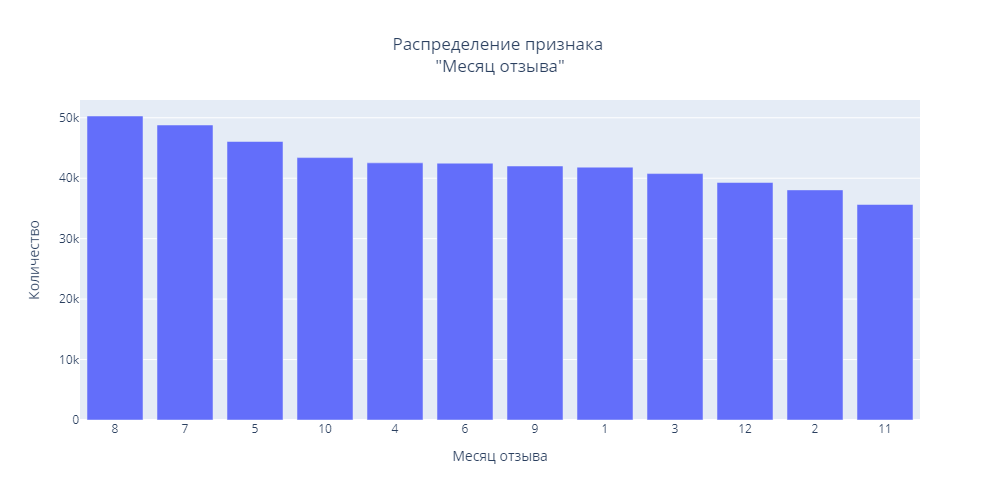

Статистические данные признака:


count    511206.000000
mean          6.485530
std           3.352482
min           1.000000
25%           4.000000
50%           7.000000
75%           9.000000
max          12.000000
Name: review_month, dtype: float64

Top-10 значений (%):


review_month
8     9.84
7     9.55
5     9.01
10    8.49
4     8.32
6     8.31
9     8.22
1     8.18
3     7.97
12    7.68
Name: proportion, dtype: float64

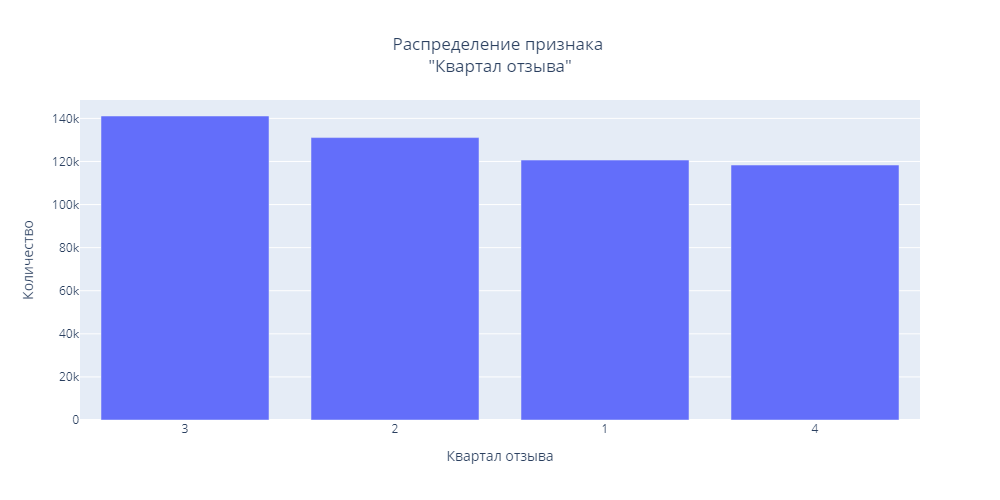

Статистические данные признака:


count    511206.000000
mean          2.503012
std           1.088596
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: review_quarter, dtype: float64

Top-10 значений (%):


review_quarter
3    27.60
2    25.64
1    23.60
4    23.15
Name: proportion, dtype: float64

In [51]:
dict_col_name_rus = {'review_month': 'Месяц отзыва',
                     'review_quarter': 'Квартал отзыва'}

# Построение гистограммы распределения каждого числового признака
for col in dict_col_name_rus:
    plot_categorical_feature(df_hotels, col, dict_col_name_rus[col])

В контексте задачи имеет смысл рассматривать полученные признаки в качестве номинальных категориальных, так как предполагается зависимость отзыва от периода/сезона его составления (близкого к посещению).

Максимальное количество отзывов составлено в августе/третьем квартале, минимальное - в ноябре/четвертом квартале.

### Очистка от исходных признаков и приведение типов

На данном этапе удаляем исходные признаки 'hotel_address', 'review_date', 'negative_review', 'positive_review' и 'tags', из которых были сгенерированы другие, а также признак 'country', так как он абсолютно идентичен признаку 'country_city'.

In [52]:
df_hotels.drop(['hotel_address', 'review_date', 'negative_review', 
                'positive_review', 'tags', 'country'],
               axis = 1, inplace=True)

In [53]:
df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511206 entries, 0 to 128934
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                511206 non-null  int64  
 1   average_score                               511206 non-null  float64
 2   hotel_name                                  511206 non-null  object 
 3   reviewer_nationality                        511206 non-null  object 
 4   review_total_negative_word_counts           511206 non-null  int64  
 5   total_number_of_reviews                     511206 non-null  int64  
 6   review_total_positive_word_counts           511206 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  511206 non-null  int64  
 8   reviewer_score                              511206 non-null  float64
 9   days_since_review                           511206 non-null  int64  
 10  l

In [54]:
# Преобразование типов признаков по их смысловому значению
df_hotels['hotel_name'] = df_hotels['hotel_name'].astype('category')
df_hotels['country_city'] = df_hotels['country_city'].astype('category')
df_hotels['review_month'] = df_hotels['review_month'].astype('category')
df_hotels['review_quarter'] = df_hotels['review_quarter'].astype('category')
df_hotels['reviewer_nationality'] = df_hotels['reviewer_nationality'].astype('category')
df_hotels['stayed_nights'] = df_hotels['stayed_nights'].astype('int64')

df_hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511206 entries, 0 to 128934
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                511206 non-null  int64   
 1   average_score                               511206 non-null  float64 
 2   hotel_name                                  511206 non-null  category
 3   reviewer_nationality                        511206 non-null  category
 4   review_total_negative_word_counts           511206 non-null  int64   
 5   total_number_of_reviews                     511206 non-null  int64   
 6   review_total_positive_word_counts           511206 non-null  int64   
 7   total_number_of_reviews_reviewer_has_given  511206 non-null  int64   
 8   reviewer_score                              511206 non-null  float64 
 9   days_since_review                           511206 non-null  int

На данном этапе проведена очистка данных, выполнен одномерный статистический анализ, проектирование признаков, приведены их типы.  
Объем статистической выборки составляет 511206 отзывов по 39 признакам. При этом 5 признаков, переведенных в разряд категориальных необходимо закодировать.

---

### Проверка влияния признаков на целевой показатель с использованием статистических гипотез

Для проверки нормальности распределения числовых признаков ввиду большого объема целесообразно использование комбинации результатов тестов Колмогорова-Смирнова и Д’Агостино (если хотябы один из тестов отрицает нормальность распределения, признаем распределение отличным от нормального).

Влияние числовых признаков на целевой параметр оцениваем через степень корреляции:
- для нормально распределенных признаков - корреляция Пирсона;
- если распределение хотябы одного из них отлично от нормального - корреляция Спирмена.

Для оценки влияния категориальных признаков на целевой параметр производим разделение выборки целевой параметра по вариантам значений каждого признака. В текущих условиях принимаем получаемые группы как независимые:
- если в признаке **два варианта значений** при нормальном распределении целевого показателя - *двухвыборочный t-критерий*, иначе - *U-критерий Манна-Уитни*;
- если в признаке **три и более варианта значений** при нормальном распределении целевого показателя - *ANOVA*, иначе - *критерий Краскела-Уоллиса*.
В качестве нулевой гипотезы принимаем отсутствие влияния значений признака на целевой параметр, то есть равенство значений μ для каждой выделенной группы:
$$ H_0 : μ_1 = ... = μ_n$$
где n - количество вариантов значений признака. Таким образом, *альтернативная гипотеза*: существует зависимость целевого параметра от вариантов значений признака, то есть:
$$ H_1 : μ_1 \neq ... \neq μ_n$$


In [55]:
# Целевой предсказываемый показатель (числовой)
target_sign = 'reviewer_score'
# Исключаемые признаки (служебные)
excluded_features = ['is_test_dataset']
# Исключаем из исходного датасета тестовые данные и служебные признаки
t_date = df_hotels[~df_hotels['is_test_dataset']].drop(excluded_features, axis=1)
# Получение категориальных (типа category и bool) и числовых признаков (int и float)
list_num_col = []
list_cat_col = []
for col in t_date.columns:
    if pd.api.types.is_float_dtype(t_date[col].dtype) \
       or pd.api.types.is_integer_dtype(t_date[col].dtype):
        list_num_col.append(col)
    else:
        list_cat_col.append(col)
# Получение типов распределения числовых признаков
# True - нормальное распределение, False - отличное от нормального
dict_num_distribution_is_norm = {}
for col in list_num_col:
    dict_num_distribution_is_norm[col] = (stats.kstest(t_date[col], 'norm')[1] > 0.05) \
                                         and (stats.normaltest(t_date[col])[1] > 0.05)
# Определение влияния каждого признака на целевой параметр в зависимости от
# типов признаков, варианта распределения и количества уникальных значений признака (для категориальных)
print('Зависимость целевого параметра от числовых признаков:')
for col in list_num_col:
    if col != target_sign \
       and dict_num_distribution_is_norm[target_sign] \
       and dict_num_distribution_is_norm[col]:
        correlation, p_value = stats.pearsonr(t_date[col], t_date[target_sign])
        if p_value < 0.05:
            if abs(correlation) > 0.3:
                print(f'Корреляция Пирсона: {correlation}, присутствует линейная зависимость от {col}')
            else:
                print(f'Корреляция Пирсона: {correlation}, линейная зависимость от {col} слабая')
        else:
            print(f'Корреляция Пирсона: {correlation}, между признаками линейная зависимость отсутствует')
    elif col != target_sign:
        rho, p_value = stats.spearmanr(t_date[col], t_date[target_sign])
        if p_value < 0.05:
            if abs(rho) > 0.05:
                print(f'Коэффициент Спирмена: {rho:.2f}, присутствует статистически значимая зависимость от {col}')
            else:
                print(f'Коэффициент Спирмена: {rho:.2f}, статистически значимая зависимость от {col} слабая')
        else:
            print(f'Коэффициент Спирмена: {rho:.2f}, статистически значимая зависимость от {col} отсутствует')

Зависимость целевого параметра от числовых признаков:
Коэффициент Спирмена: -0.05, присутствует статистически значимая зависимость от additional_number_of_scoring
Коэффициент Спирмена: 0.35, присутствует статистически значимая зависимость от average_score
Коэффициент Спирмена: -0.47, присутствует статистически значимая зависимость от review_total_negative_word_counts
Коэффициент Спирмена: -0.08, присутствует статистически значимая зависимость от total_number_of_reviews
Коэффициент Спирмена: 0.31, присутствует статистически значимая зависимость от review_total_positive_word_counts
Коэффициент Спирмена: -0.03, статистически значимая зависимость от total_number_of_reviews_reviewer_has_given слабая
Коэффициент Спирмена: -0.00, статистически значимая зависимость от days_since_review слабая
Коэффициент Спирмена: -0.02, статистически значимая зависимость от lat слабая
Коэффициент Спирмена: 0.06, присутствует статистически значимая зависимость от lng
Коэффициент Спирмена: -0.10, присутствует с

При рассмотрении категориальных признаков введем ограничение на количество проверяемых групп, чтобы уменьшить влияние выбросов на результаты статистических тестов.

In [56]:
print('Зависимость целевого параметра от категориальных признаков:')
for col in list_cat_col:
    lst_groups = []
    # Ограничение количества рассматриваемых групп для признаков с большим количеством уникальных значений
    count_groups = 0
    for val in t_date[col].value_counts().index:
        if count_groups < 300:
            count_groups += 1
            lst_groups.append(t_date[t_date[col] == val][col])
        else:
            break
    if t_date[col].nunique() == 2:
        if dict_num_distribution_is_norm[target_sign]:
            # Двухвыборочный t-критерий
            param, p = stats.ttest_ind(lst_groups[0], lst_groups[1],
                                       alternative='two-sided',
                                       equal_var=(stats.levene(lst_groups[0], lst_groups[1])[1] > 0.05))
            if p <= 0.05:
                print(f't-статистика (сила разницы): {param:.2f}, присутствует статистически значимая зависимость от {col}')
            else:
                print(f't-статистика (сила разницы): {param:.2f}, статистически значимая зависимость от {col} отсутствует')
        else:
            # U-критерий Манна-Уитни
            param, p = stats.mannwhitneyu(lst_groups[0], lst_groups[1],
                                          alternative='two-sided')
            if p <= 0.05:
                print(f'U-статистика: {param:.2f}, присутствует статистически значимая зависимость от {col}')
            else:
                print(f'U-статистика: {param:.2f}, статистически значимая зависимость от {col} отсутствует')
    else:        
        if dict_num_distribution_is_norm[target_sign]:
            # ANOVA
            param, p = stats.f_oneway(*lst_groups)
            if p <= 0.05:
                print(f'ANOVA: {param:.2f}, присутствует статистически значимая зависимость от {col}')
            else:
                print(f'ANOVA: {param:.2f}, статистически значимая зависимость от {col} отсутствует')
        else:
            # Критерий Краскела-Уоллиса
            param, p = stats.kruskal(*lst_groups)
            if p <= 0.05:
                print(f'Критерий Краскела-Уоллиса: {param:.2f}, присутствует статистически значимая зависимость от {col}')
            else:
                print(f'Критерий Краскела-Уоллиса: {param:.2f}, статистически значимая зависимость от {col} отсутствует')

Зависимость целевого параметра от категориальных признаков:
Критерий Краскела-Уоллиса: 225470.00, присутствует статистически значимая зависимость от hotel_name
Критерий Краскела-Уоллиса: nan, статистически значимая зависимость от reviewer_nationality отсутствует
Критерий Краскела-Уоллиса: 382270.00, присутствует статистически значимая зависимость от country_city
U-статистика: 33100049850.00, присутствует статистически значимая зависимость от foreign_guest
U-статистика: 18047249878.00, присутствует статистически значимая зависимость от religion_christianity
U-статистика: 0.00, присутствует статистически значимая зависимость от religion_islam
U-статистика: 0.00, присутствует статистически значимая зависимость от religion_judaism
U-статистика: 0.00, присутствует статистически значимая зависимость от religion_hinduism
U-статистика: 0.00, присутствует статистически значимая зависимость от religion_buddhism
U-статистика: 19533443818.00, присутствует статистически значимая зависимость от is_l

В ходе проверки влияния признаков на оценку рецензента с использованием статистических гипотез отмечается отсутствие зависимости от признаков:
- reviewer_nationality;  

слабая зависимость от признаков:
- total_number_of_reviews_reviewer_has_given;
- days_since_review;
- lat;
- tags_count;
- stayed_nights.  

Для повышения качества модели необходимо исключить признаки, от которых целевой показатель не зависит. Признаки даже со слабой зависимостью могут быть полезны, поэтому решение об их вхождении в состав модели будет приниматься в ходе проведения экспериментов с последующей оценкой модели.

In [57]:
del_cols = ['reviewer_nationality']
df_hotels.drop(del_cols, axis = 1, inplace=True)

---

## Кодирование и отбор признаков

### Кодирование признаков

Выбор метода кодирования:
- 'hotel_name' - 1493 уникальных значения, преобразуем бинарным кодированием;
- 'country_city' - 6 уникальных значений, преобразуем однократным кодированием;
- 'review_month' - 12 уникальных значений, преобразуем однократным кодированием;
- 'review_quarter' - 4 уникальных значения, преобразуем однократным кодированием.

In [58]:
# Бинарное кодирование
coded_cols = ['hotel_name']
bin_encoder = ce.BinaryEncoder(cols=coded_cols)
type_bin = bin_encoder.fit_transform(df_hotels[coded_cols])
df_hotels_coded = pd.concat([df_hotels, type_bin], axis=1)
df_hotels_coded.drop(coded_cols, axis = 1, inplace=True)

# Однократное кодирование
coded_cols = ['country_city', 'review_quarter', 'review_month']
one_hot_encoder = ce.OneHotEncoder(cols=coded_cols)
type_bin = one_hot_encoder.fit_transform(df_hotels[coded_cols])
df_hotels_coded = pd.concat([df_hotels_coded, type_bin], axis=1)
# Удаление исходных признаков
df_hotels_coded.drop(coded_cols, axis = 1, inplace=True)

df_hotels_coded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 511206 entries, 0 to 128934
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                511206 non-null  int64  
 1   average_score                               511206 non-null  float64
 2   review_total_negative_word_counts           511206 non-null  int64  
 3   total_number_of_reviews                     511206 non-null  int64  
 4   review_total_positive_word_counts           511206 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  511206 non-null  int64  
 6   reviewer_score                              511206 non-null  float64
 7   days_since_review                           511206 non-null  int64  
 8   lat                                         511206 non-null  float64
 9   lng                                         511206 non-null  float64
 10  i

Датасет со всеми закодированными признаками содержит 67 признаков. Для исключения явления мультиколлинеарности проведем анализ признаков по степени их взаимной корреляции.

Пары сильно коррелирующих признаков:
total_number_of_reviews - additional_number_of_scoring
is_test_dataset - reviewer_score
religion_islam - religion_christianity
tag_from_mobile - tags_count
country_city_5 - lng
country_city_6 - lat


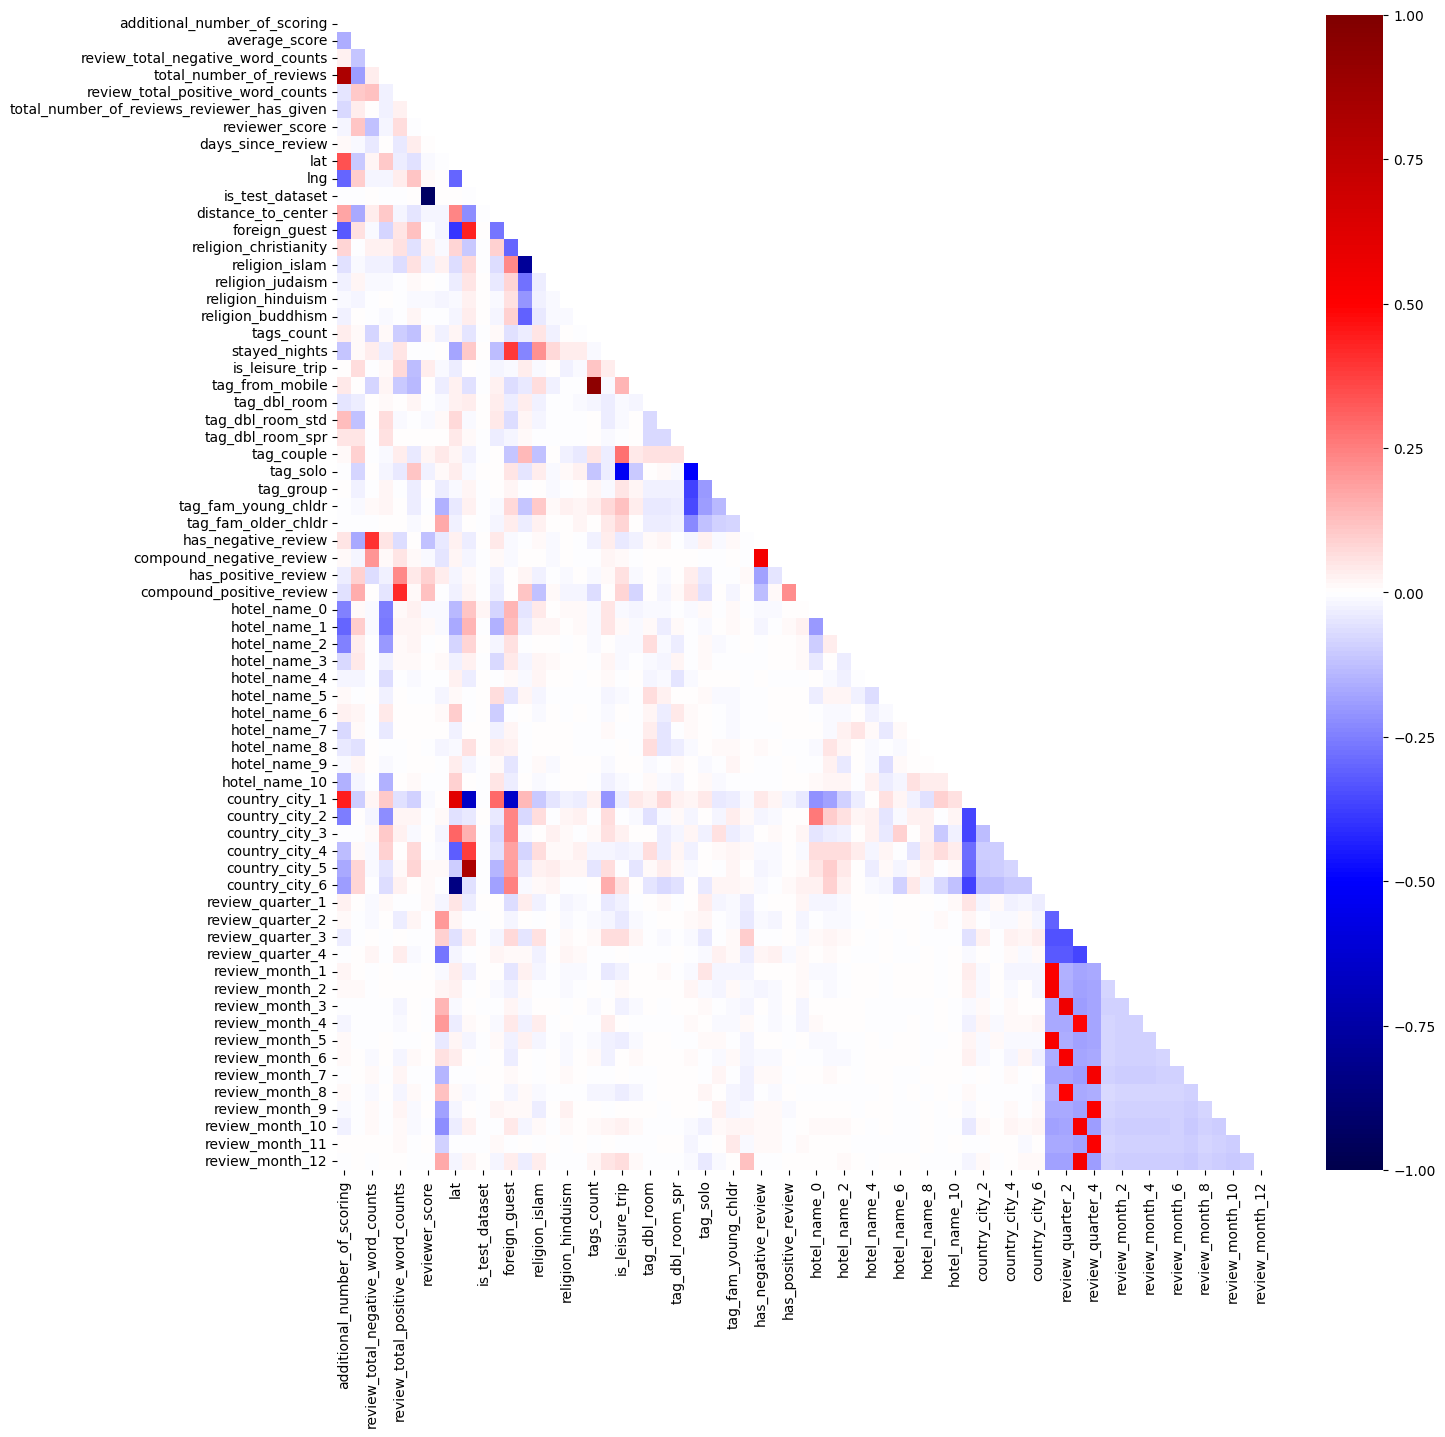

In [59]:
df_corr = df_hotels_coded.corr(method='pearson', numeric_only=True)
# Вычисление списка пар сильно коррелирующих признаков
print('Пары сильно коррелирующих признаков:')
for i in range(1, df_corr.shape[0]):
    for j in range(0, i):
        if df_corr.iloc[i, j] >= 0.7 or df_corr.iloc[i, j] <= -0.7:
            print(f'{df_corr.index[i]} - {df_corr.columns[j]}')
            
# Матрица корреляций
plt.figure(figsize=(15, 15))
sns.heatmap(df_hotels_coded.corr(numeric_only=True),
            annot=False, # Подпись данных
            vmin=-1, vmax=1,
            center=0,
            cmap='seismic',
            mask=np.triu(df_hotels_coded.corr(numeric_only=True)))
plt.show()

При выявлении сильной корреляции признаков предпочтение отдаем признакам, имеющим большее количество уникальных значений. Таким образом при сравнении признаков широты и долготы с частями закодированного признака Страна_город в качестве удаляемых выбираем признаки 'country_city_5' и 'country_city_6'.
В паре 'Количество действительных оценок без проверки' (additional_number_of_scoring) - 'Общее количество действительных отзывов отеля' (total_number_of_reviews) оставляем признак общего количества действительных отзывов отеля. В паре признаков tag_from_mobile - tags_count в качестве удаляемого выбираем tag_from_mobile.

In [60]:
# Удаление признаков
del_cols = ['religion_christianity', 'country_city_5', 'country_city_6',
            'additional_number_of_scoring', 'tag_from_mobile']
df_hotels_coded.drop(del_cols, axis = 1, inplace=True)

---

## Формирование и оценка модели

In [61]:
# Теперь выделим тестовую часть
train_data = df_hotels_coded[~(df_hotels_coded['is_test_dataset'])].drop(['is_test_dataset'], axis=1)
test_data = df_hotels_coded[df_hotels_coded['is_test_dataset']].drop(['is_test_dataset'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [62]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 61), (382271, 61), (382271, 60), (305816, 60), (76455, 60))

In [64]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

In [65]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.5s finished


In [66]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12368878021378388


По условиям задания показатель MAPE не должен превышать 13.5%, текущий показатель модели равен 12.37%, что удовлетворяет решению задачи в полной мере.

<Axes: >

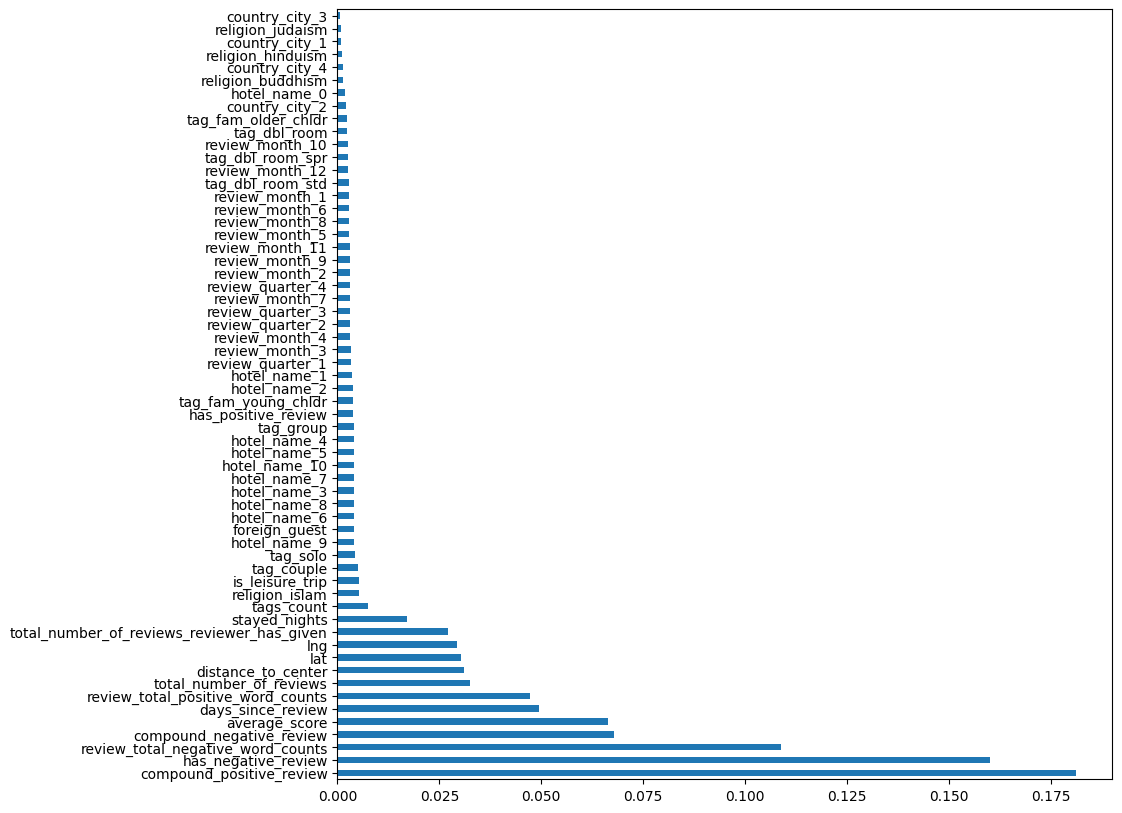

In [67]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(70).plot(kind='barh')

Наибольшее влияние на модель оказали:
- Сводная оценка положительного отзыва;
- Наличие негативного отзыва;
- Общее количество слов отрицательного отзыва;
- Сводная оценка отрицательного отзыва;
- Средний балл отеля за последний год;
- Количество дней между датой проверки и датой очистки;
- Общее количество слов положительного отзыва;
- Общее количество действительных отзывов отеля;
- Расстояние от отеля до центра города;
- Широта;
- Долгота;
- Количество отзывов отеля;
- Количество проведенных ночей.  

Остальные признаки оказали не столь значительное влияние.

In [68]:
# Обзор примера данных, подготовленных для соревнования на Kaggle
sample_submission = pd.read_csv('./data/submission.csv')
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,distance_to_center,...,review_month_3,review_month_4,review_month_5,review_month_6,review_month_7,review_month_8,review_month_9,review_month_10,review_month_11,review_month_12
3753,8.5,114,2279,14,13,0.0,249,48.204465,16.370240,0.469435,...,0,0,0,0,0,1,0,0,0,0
55410,8.4,12,2140,28,6,0.0,509,51.512649,-0.180379,3.821298,...,0,0,1,0,0,0,0,0,0,0
76062,8.1,54,1991,3,17,0.0,424,41.433756,2.147327,5.088333,...,0,0,0,0,0,0,1,0,0,0
13266,8.7,2,5394,6,4,0.0,140,51.498673,-0.137687,1.372380,...,0,0,1,0,0,0,0,0,0,0
26256,9.4,0,1353,4,2,0.0,471,48.197550,16.368640,1.244481,...,0,0,0,0,0,0,0,0,1,0
32025,8.4,135,3340,6,3,0.0,679,41.384284,2.170709,1.100584,...,0,1,0,0,0,0,0,0,0,0
3577,7.9,0,6511,3,3,0.0,710,48.875898,2.359050,2.612539,...,0,0,0,0,0,0,0,0,0,1
61853,7.5,22,3811,15,1,0.0,130,45.499520,9.206138,4.124627,...,0,0,1,0,0,0,0,0,0,0
104850,8.7,77,12158,24,1,0.0,379,51.500961,-0.116591,1.052174,...,0,0,0,0,0,0,0,1,0,0
73753,8.7,2,12158,9,2,0.0,93,51.500961,-0.116591,1.052174,...,0,0,0,0,1,0,0,0,0,0


In [69]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [70]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.0s finished


In [71]:
predict_submission

array([8.762, 7.436, 7.874, ..., 7.974, 9.61 , 7.432])

In [72]:
list(sample_submission)

['reviewer_score', 'id']

In [73]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.762,488440
1,7.436,274649
2,7.874,374688
3,9.676,404352
4,9.604,451596
5,8.836,302161
6,7.584,317079
7,7.753,13963
8,8.645,159785
9,7.658,195089


Экспериментально были подтверждены следующие утверждения:
- нормализация числовых признаков отрицательно повлияла на качество модели;
- удаление из датасета модели признаков, слабо влияющих на целевой параметр, привело к ухудшению показателя качества модели.